In [7]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
from shapely.ops import unary_union
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import rasterio
import rasterstats
from rasterio.plot import show
from rasterio.plot import show_hist
import osmnx as ox
import folium
import requests

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
pd.options.display.max_columns = 200

# Dependent Variable

## PLACEs data processing

PLACES reports county-, place-, census tract-, and ZCTA-level data and uses small area estimation methods to obtain 29 (27 in the 2020 release) chronic disease measures for the entire United States. PLACE 2021 version mearsures 2019 and 2018 health related data

**Detail Information:** https://www.cdc.gov/places/

**Source:** https://chronicdata.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-Census-Tract-D/cwsq-ngmh

**Geography:** Census Tract

**Date:** 2019 (release December 1, 2021)

In [3]:
# read cdc PLACEs health data
PLACEs = pd.read_csv('./Data/Raw_Data/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv'
                    ,usecols=['Year','StateAbbr','CountyName','Category','Measure','Data_Value','TotalPopulation','Geolocation','LocationID','MeasureId','CategoryID']
                    )
PLACEs.head()

Year StateAbbr CountyName         Category  \
0  2019        AR  Craighead  Health Outcomes   
1  2019        AR  Craighead  Health Outcomes   
2  2019        CA    Alameda  Health Outcomes   
3  2019        CA    Alameda  Health Outcomes   
4  2019        CA    Alameda  Health Outcomes   

                                   Measure  Data_Value  TotalPopulation  \
0      Stroke among adults aged >=18 years         3.5             6516   
1  Depression among adults aged >=18 years        26.2             6139   
2      Stroke among adults aged >=18 years         7.4             2788   
3     Obesity among adults aged >=18 years        26.3             2238   
4   Arthritis among adults aged >=18 years        15.8             2819   

                        Geolocation  LocationID CategoryID   MeasureId  
0  POINT (-90.71822092 35.81904551)  5031000300    HLTHOUT      STROKE  
1  POINT (-90.61608228 35.87373244)  5031000501    HLTHOUT  DEPRESSION  
2  POINT (-122.2706945 37.80052483)  6001403000    HLTHOUT      STROKE  
3  POINT (-122.2754581 37.80233855)  6001403100    HLTHOUT     OBESITY  
4  POINT (-122.2536907 37.82326962)  6001404000    HLTHOUT   ARTHRITIS

In [4]:
# select data in NYC
PLACEsNY = PLACEs[PLACEs['StateAbbr'] == 'NY']
PLACEsNY = PLACEsNY[PLACEsNY['CountyName'].isin(['Bronx','Kings','New York','Queens','Richmond'])]
PLACEsNY.head()

Year StateAbbr CountyName               Category  \
1240910  2019        NY      Bronx  Health Risk Behaviors   
1240911  2019        NY      Bronx        Health Outcomes   
1240914  2018        NY      Bronx             Prevention   
1240916  2018        NY      Bronx             Prevention   
1240918  2019        NY      Bronx        Health Outcomes   

                                                   Measure  Data_Value  \
1240910  No leisure-time physical activity among adults...        34.9   
1240911    Diagnosed diabetes among adults aged >=18 years        15.7   
1240914  Fecal occult blood test, sigmoidoscopy, or col...        43.6   
1240916  Older adult men aged >=65 years who are up to ...        24.1   
1240918  Cancer (excluding skin cancer) among adults ag...         4.0   

         TotalPopulation                       Geolocation   LocationID  \
1240910             1907   POINT (-73.9128415 40.81821599)  36005007100   
1240911             2303  POINT (-73.85902728 40.87309199)  36005037000   
1240914            11091   POINT (-73.88265696 40.7911001)  36005000100   
1240916             3598  POINT (-73.83457776 40.88631153)  36005048400   
1240918             1699  POINT (-73.91326373 40.84449183)  36005022702   

        CategoryID     MeasureId  
1240910    RISKBEH           LPA  
1240911    HLTHOUT      DIABETES  
1240914    PREVENT  COLON_SCREEN  
1240916    PREVENT         COREM  
1240918    HLTHOUT        CANCER

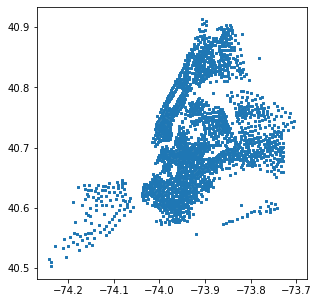

In [5]:
# take a look at the spatial distribution of health data
a = PLACEsNY.copy()
a['Geolocation'] = a['Geolocation'].apply(wkt.loads)
a = gpd.GeoDataFrame(a,geometry=a['Geolocation'],crs=4326)
a.plot(markersize=1, figsize=(5,5))
plt.show()

### Spatial join with ct2010 census tract boundary 
### (Although the latest file is ct2020, consider for compatibility with all data location id, we use ct2010)

In [6]:
ct2010 = gpd.read_file('./Data/Raw_Data/Geo/2010_Census_Tracts/geo_export_56c76d30-fb47-4fa6-839d-06b327544523.shp')
ct2010.head()

boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0         5    5000900  Staten Island          E  000900       9    SI22   
1         1    1009800      Manhattan          I  009800      98    MN19   
2         1    1010200      Manhattan          I  010200     102    MN17   
3         1    1010400      Manhattan          I  010400     104    MN17   
4         1    1011300      Manhattan          I  011300     113    MN17   

                                     ntaname  puma    shape_area   shape_leng  \
0  West New Brighton-New Brighton-St. George  3903  2.497010e+06  7729.016794   
1                    Turtle Bay-East Midtown  3808  1.906016e+06  5534.200308   
2                      Midtown-Midtown South  3807  1.860993e+06  5687.802439   
3                      Midtown-Midtown South  3807  1.864600e+06  5693.036367   
4                      Midtown-Midtown South  3807  1.890907e+06  5699.860640   

                                            geometry  
0  POLYGON ((-74.07921 40.64343, -74.07914 40.643...  
1  POLYGON ((-73.96433 40.75638, -73.96479 40.755...  
2  POLYGON ((-73.97124 40.76094, -73.97170 40.760...  
3  POLYGON ((-73.97446 40.76229, -73.97491 40.761...  
4  POLYGON ((-73.98412 40.75484, -73.98460 40.754...

In [7]:
# check null value
ct2010.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   boro_code   2165 non-null   object  
 1   boro_ct201  2165 non-null   object  
 2   boro_name   2165 non-null   object  
 3   cdeligibil  2164 non-null   object  
 4   ct2010      2165 non-null   object  
 5   ctlabel     2165 non-null   object  
 6   ntacode     2165 non-null   object  
 7   ntaname     2165 non-null   object  
 8   puma        2165 non-null   object  
 9   shape_area  2165 non-null   float64 
 10  shape_leng  2165 non-null   float64 
 11  geometry    2165 non-null   geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 203.1+ KB


In [8]:
# check duplicate
ct2010[ct2010.duplicated()]

Empty GeoDataFrame
Columns: [boro_code, boro_ct201, boro_name, cdeligibil, ct2010, ctlabel, ntacode, ntaname, puma, shape_area, shape_leng, geometry]
Index: []

In [9]:
# crate ct2010 GeoID for match PLACEs data

ct2010['GeoID']=0
for i in range(len(ct2010['boro_name'])):
    if (ct2010['boro_name'][i]=='Manhattan'):
        ct2010['GeoID'][i] = '36061'+ ct2010['ct2010'][i]
    
    elif (ct2010['boro_name'][i]=='Bronx'):
        ct2010['GeoID'][i] = '36005'+ ct2010['ct2010'][i]
        
    elif (ct2010['boro_name'][i]=='Queens'):
        ct2010['GeoID'][i] = '36081'+ ct2010['ct2010'][i]
    
    elif (ct2010['boro_name'][i]=='Brooklyn'):
        ct2010['GeoID'][i] = '36047'+ ct2010['ct2010'][i]
    
    elif (ct2010['boro_name'][i]=='Staten Island'):
        ct2010['GeoID'][i] = '36085'+ ct2010['ct2010'][i]
    
    else:
        print('no')

ct2010.head()  

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import ke

boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0         5    5000900  Staten Island          E  000900       9    SI22   
1         1    1009800      Manhattan          I  009800      98    MN19   
2         1    1010200      Manhattan          I  010200     102    MN17   
3         1    1010400      Manhattan          I  010400     104    MN17   
4         1    1011300      Manhattan          I  011300     113    MN17   

                                     ntaname  puma    shape_area   shape_leng  \
0  West New Brighton-New Brighton-St. George  3903  2.497010e+06  7729.016794   
1                    Turtle Bay-East Midtown  3808  1.906016e+06  5534.200308   
2                      Midtown-Midtown South  3807  1.860993e+06  5687.802439   
3                      Midtown-Midtown South  3807  1.864600e+06  5693.036367   
4                      Midtown-Midtown South  3807  1.890907e+06  5699.860640   

                                            geometry        GeoID  
0  POLYGON ((-74.07921 40.64343, -74.07914 40.643...  36085000900  
1  POLYGON ((-73.96433 40.75638, -73.96479 40.755...  36061009800  
2  POLYGON ((-73.97124 40.76094, -73.97170 40.760...  36061010200  
3  POLYGON ((-73.97446 40.76229, -73.97491 40.761...  36061010400  
4  POLYGON ((-73.98412 40.75484, -73.98460 40.754...  36061011300

In [96]:
# save this geo file
ct2010.to_file('./Data/Processed_Data/ct2010_geoid.geojson', driver='GeoJSON')

In [10]:
len(PLACEsNY)

63498

In [11]:
# health data merge with ct2010 
PLACEsNY_Geo = pd.merge(PLACEsNY, ct2010, left_on='LocationID', right_on='GeoID')
PLACEsNY_Geo = gpd.GeoDataFrame(PLACEsNY_Geo, geometry=PLACEsNY_Geo['geometry'],crs={'init':'epsg:4326'})
len(PLACEsNY_Geo)

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


63498

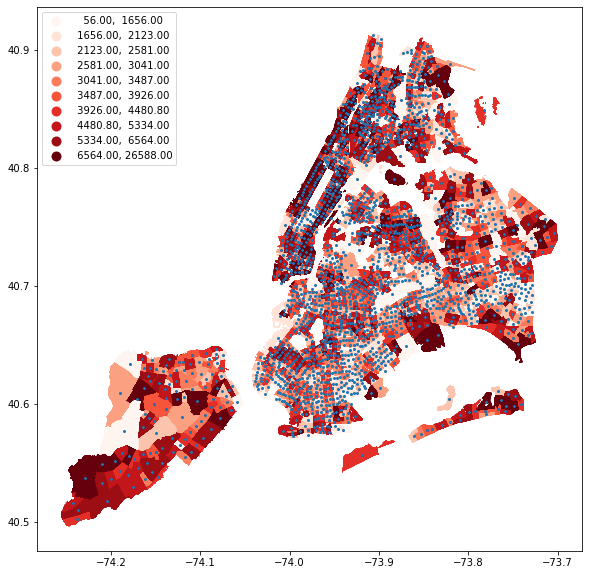

In [14]:
# take a look at if these two data sets merge well
base = PLACEsNY_Geo.plot(column='TotalPopulation', cmap='Reds', 
                              legend=True, scheme='Quantiles', k=10,
                              figsize=(10,10))

a.plot(ax=base, markersize=0.5, figsize=(10,10));
plt.show()

### Fillter out the census tracts which population lower than 1000
The disease rate of a small number of people in a census tract is scarcely typical of the overall condition; for example, if there are only ten persons in a region and five of them are obese, the obesity rate is 50%, which is clearly unacceptably high.

In [36]:
PLACEsNY_clean_Geo = PLACEsNY_Geo[PLACEsNY_Geo['TotalPopulation'] >= 1000]
len(PLACEsNY_clean_Geo)                            

62550

Check if the county name of PLACE can be matched with the county name of ct2010.

In [37]:
PLACEsNY_clean_Geo.CountyName.unique()

array(['Bronx', 'Kings', 'New York', 'Queens', 'Richmond'], dtype=object)

In [38]:
PLACEsNY_clean_Geo.boro_name.unique()

array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object)

In [39]:
print(len(PLACEsNY_clean_Geo[(PLACEsNY_clean_Geo['CountyName'] == 'Bronx')\
                       & (PLACEsNY_clean_Geo['boro_name'] != 'Bronx')]))

print(len(PLACEsNY_clean_Geo[(PLACEsNY_clean_Geo['CountyName'] == 'Kings')\
                       & (PLACEsNY_clean_Geo['boro_name'] != 'Brooklyn')]))

print(len(PLACEsNY_clean_Geo[(PLACEsNY_clean_Geo['CountyName'] == 'New York')\
                       & (PLACEsNY_clean_Geo['boro_name'] != 'Manhattan')]))

print(len(PLACEsNY_clean_Geo[(PLACEsNY_clean_Geo['CountyName'] == 'Queens')\
                       & (PLACEsNY_clean_Geo['boro_name'] != 'Queens')]))

print(len(PLACEsNY_clean_Geo[(PLACEsNY_clean_Geo['CountyName'] == 'Richmond')\
                       & (PLACEsNY_clean_Geo['boro_name'] != 'Staten Island')]))

0
0
0
0
0


In [40]:
PLACEsNY_clean_Geo = PLACEsNY_clean_Geo.drop(['CountyName','boro_code','boro_ct201','cdeligibil','ctlabel','puma','LocationID','Geolocation'],axis=1)
PLACEsNY_clean_Geo.head()

Year StateAbbr               Category  \
0  2019        NY  Health Risk Behaviors   
1  2019        NY             Prevention   
2  2018        NY  Health Risk Behaviors   
3  2019        NY        Health Outcomes   
4  2019        NY        Health Outcomes   

                                             Measure  Data_Value  \
0  No leisure-time physical activity among adults...        34.9   
1  Current lack of health insurance among adults ...        23.3   
2  Sleeping less than 7 hours among adults aged >...        41.1   
3  Cancer (excluding skin cancer) among adults ag...         4.7   
4                Stroke among adults aged >=18 years         3.3   

   TotalPopulation CategoryID MeasureId boro_name  ct2010 ntacode  \
0             1907    RISKBEH       LPA     Bronx  007100    BX34   
1             1907    PREVENT   ACCESS2     Bronx  007100    BX34   
2             1907    RISKBEH     SLEEP     Bronx  007100    BX34   
3             1907    HLTHOUT    CANCER     Bronx  007100    BX34   
4             1907    HLTHOUT    STROKE     Bronx  007100    BX34   

                          ntaname    shape_area  shape_leng  \
0  Melrose South-Mott Haven North  2.841871e+06  8603.54257   
1  Melrose South-Mott Haven North  2.841871e+06  8603.54257   
2  Melrose South-Mott Haven North  2.841871e+06  8603.54257   
3  Melrose South-Mott Haven North  2.841871e+06  8603.54257   
4  Melrose South-Mott Haven North  2.841871e+06  8603.54257   

                                            geometry        GeoID  
0  POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
1  POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
2  POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
3  POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
4  POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100

In [41]:
PLACEsNY_clean_Geo.describe()

Year    Data_Value  TotalPopulation    shape_area  \
count  62550.000000  62550.000000     62550.000000  6.255000e+04   
mean    2018.733333     30.613741      3914.597602  3.380277e+06   
std        0.442220     27.018180      2094.765579  5.167626e+06   
min     2018.000000      0.600000      1003.000000  4.478077e+05   
25%     2018.000000     11.100000      2397.000000  1.677792e+06   
50%     2019.000000     19.300000      3507.000000  1.969158e+06   
75%     2019.000000     42.400000      4917.000000  2.949066e+06   
max     2019.000000     97.300000     26588.000000  1.057417e+08   

         shape_leng         GeoID  
count  62550.000000  6.255000e+04  
mean    8136.093759  3.605460e+10  
std     5589.593829  2.595758e+07  
min     2816.869528  3.600500e+10  
25%     5602.246872  3.604702e+10  
50%     6467.648368  3.604712e+10  
75%     8457.521157  3.608103e+10  
max    93905.197358  3.608503e+10

In [105]:
#save file
PLACEsNY_clean_Geo.to_file('./Data/Processed_Data/PLACEsNY_clean_Geo.geojson', driver='GeoJSON')

### Separate Health Status and Health Outcomes

In [42]:
PLACEsNY_clean_Geo.Category.unique()

array(['Health Risk Behaviors', 'Prevention', 'Health Outcomes',
       'Health Status'], dtype=object)

In [43]:
HStatus = PLACEsNY_clean_Geo[PLACEsNY_clean_Geo['Category'] == 'Health Status']
HOutcomes = PLACEsNY_clean_Geo[PLACEsNY_clean_Geo['Category'] == 'Health Outcomes']

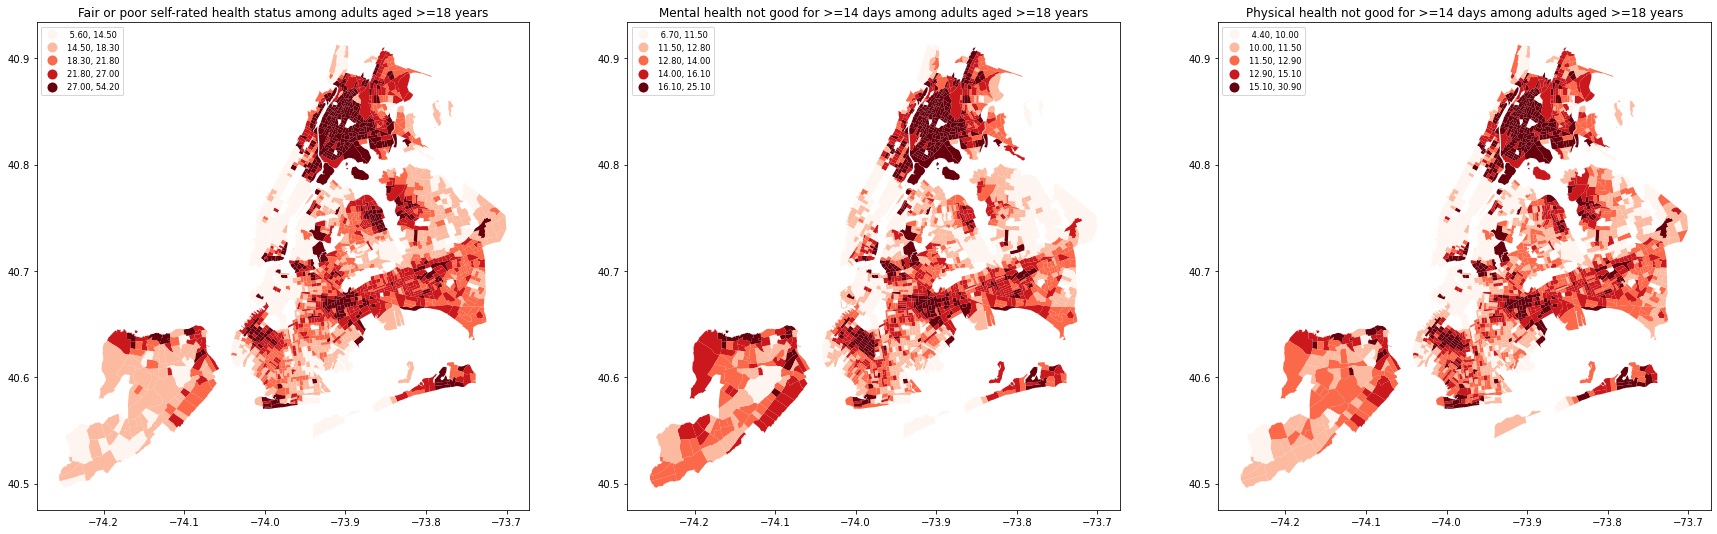

In [44]:
fig, ax = plt.subplots(1,3, figsize=(30,30))

for i,j in enumerate(HStatus['Measure'].unique()):
    HStatus[HStatus['Measure'] == j].plot(ax=ax[i], column='Data_Value', k=5, scheme='Quantiles',cmap='Reds',
                                             legend=True, legend_kwds={'loc':'upper left','fontsize':'small'})
    
    
    label = j
    ax[i].set_title(label)
    
plt.show()

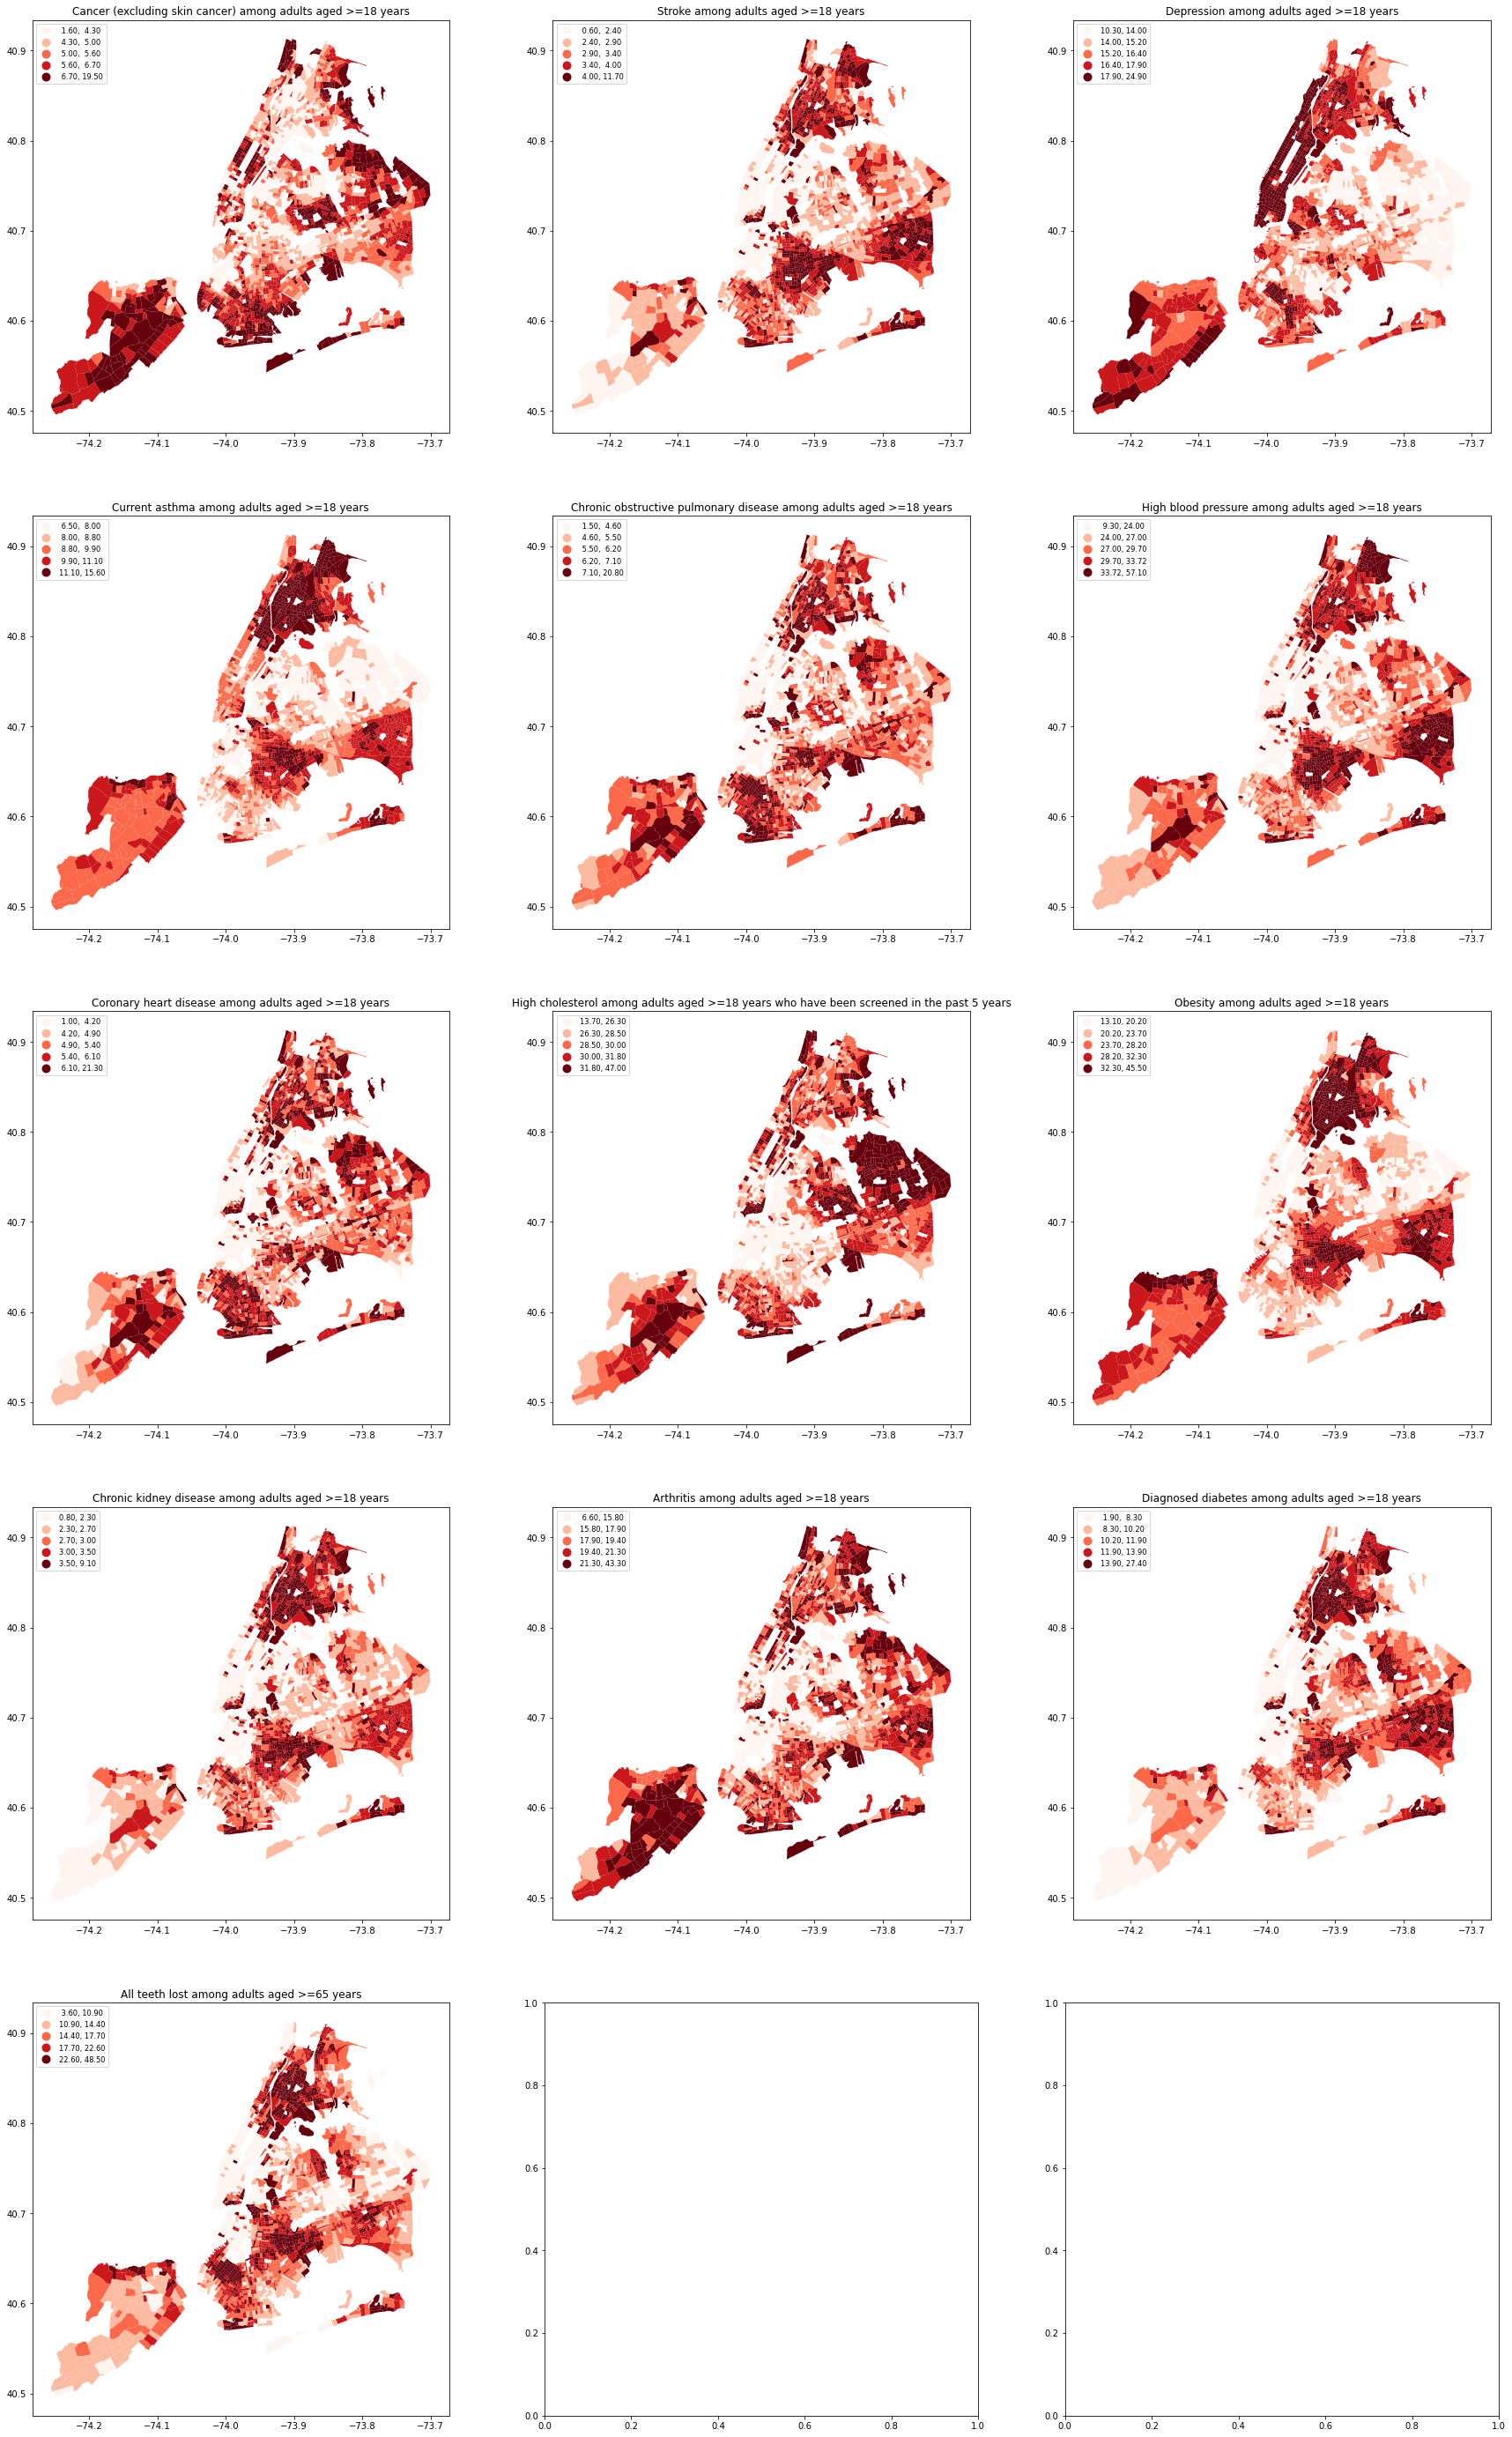

In [45]:
fig, ax = plt.subplots(5,3, figsize=(30,50))

for i,j in enumerate(HOutcomes['Measure'].unique()):
    HOutcomes[HOutcomes['Measure'] == j].plot(ax=ax[i//3][i%3], column='Data_Value', k=5, scheme='Quantiles',cmap='Reds',
                                             legend=True, legend_kwds={'loc':'upper left','fontsize':'small'})
    
    
    label = j
    ax[i//3][i%3].set_title(label)

#plt.tight_layout()
plt.show()

### Health Status
**GHLTH:** Fair or poor self-rated health status among adults aged >= 18 years
**MHLTH:** Mental health not good for >=14 days among adults aged >= 18 years
**PHLTH:** Physical health not good for >=14 days among adults aged >= 18 years

In [108]:
HStatus.head()

Year StateAbbr       Category  \
20  2019        NY  Health Status   
21  2019        NY  Health Status   
23  2019        NY  Health Status   
36  2019        NY  Health Status   
38  2019        NY  Health Status   

                                              Measure  Data_Value  \
20  Fair or poor self-rated health status among ad...        25.7   
21  Mental health not good for >=14 days among adu...        14.7   
23  Physical health not good for >=14 days among a...        13.8   
36  Physical health not good for >=14 days among a...        15.5   
38  Mental health not good for >=14 days among adu...        16.5   

    TotalPopulation CategoryID MeasureId boro_name  ct2010 ntacode  \
20             1907   HLTHSTAT     GHLTH     Bronx  007100    BX34   
21             1907   HLTHSTAT     MHLTH     Bronx  007100    BX34   
23             1907   HLTHSTAT     PHLTH     Bronx  007100    BX34   
36             2303   HLTHSTAT     PHLTH     Bronx  037000    BX44   
38             2303   HLTHSTAT     MHLTH     Bronx  037000    BX44   

                           ntaname    shape_area   shape_leng  \
20  Melrose South-Mott Haven North  2.841871e+06  8603.542570   
21  Melrose South-Mott Haven North  2.841871e+06  8603.542570   
23  Melrose South-Mott Haven North  2.841871e+06  8603.542570   
36        Williamsbridge-Olinville  1.709084e+06  5159.570728   
38        Williamsbridge-Olinville  1.709084e+06  5159.570728   

                                             geometry        GeoID  
20  POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
21  POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
23  POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
36  POLYGON ((-73.85651 40.87422, -73.85655 40.873...  36005037000  
38  POLYGON ((-73.85651 40.87422, -73.85655 40.873...  36005037000

In [109]:
# pivot table
HStatus = HStatus.pivot_table(index='GeoID',columns='MeasureId', values='Data_Value')
HStatus.head()

MeasureId    GHLTH  MHLTH  PHLTH
GeoID                           
36005000100   30.3   19.3   14.0
36005000200   25.4   13.9   13.4
36005000400   19.6   12.4   10.8
36005001600   31.1   16.0   16.8
36005001900   26.2   16.6   13.9

In [115]:
Pop =PLACEsNY.groupby('LocationID').agg({'TotalPopulation':'mean'})

In [119]:
HStatus = pd.merge(HStatus,Pop, left_index=True, right_index=True)

### Health Outcomes

In [120]:
HOutcomes.head()

Year StateAbbr         Category  \
3   2019        NY  Health Outcomes   
4   2019        NY  Health Outcomes   
5   2019        NY  Health Outcomes   
8   2019        NY  Health Outcomes   
11  2019        NY  Health Outcomes   

                                              Measure  Data_Value  \
3   Cancer (excluding skin cancer) among adults ag...         4.7   
4                 Stroke among adults aged >=18 years         3.3   
5             Depression among adults aged >=18 years        15.7   
8         Current asthma among adults aged >=18 years        11.1   
11  Chronic obstructive pulmonary disease among ad...         5.4   

    TotalPopulation CategoryID   MeasureId boro_name  ct2010 ntacode  \
3              1907    HLTHOUT      CANCER     Bronx  007100    BX34   
4              1907    HLTHOUT      STROKE     Bronx  007100    BX34   
5              1907    HLTHOUT  DEPRESSION     Bronx  007100    BX34   
8              1907    HLTHOUT     CASTHMA     Bronx  007100    BX34   
11             1907    HLTHOUT        COPD     Bronx  007100    BX34   

                           ntaname    shape_area  shape_leng  \
3   Melrose South-Mott Haven North  2.841871e+06  8603.54257   
4   Melrose South-Mott Haven North  2.841871e+06  8603.54257   
5   Melrose South-Mott Haven North  2.841871e+06  8603.54257   
8   Melrose South-Mott Haven North  2.841871e+06  8603.54257   
11  Melrose South-Mott Haven North  2.841871e+06  8603.54257   

                                             geometry        GeoID  
3   POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
4   POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
5   POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
8   POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100  
11  POLYGON ((-73.90842 40.82218, -73.90850 40.821...  36005007100

In [121]:
# pivot table
HOutcomes = HOutcomes.pivot_table(index='GeoID',columns='MeasureId', values='Data_Value')
HOutcomes.head()

MeasureId    ARTHRITIS  BPHIGH  CANCER  CASTHMA  CHD  COPD  DEPRESSION  \
GeoID                                                                    
36005000100       11.4    28.6     2.1     11.1  3.8   5.5        15.1   
36005000200       18.0    30.3     4.9     10.4  5.2   5.2        15.2   
36005000400       15.6    26.8     4.5      9.8  3.9   3.9        14.5   
36005001600       22.2    35.8     5.7     11.8  7.0   7.3        16.4   
36005001900       15.2    28.1     3.5     10.8  4.7   5.4        16.6   

MeasureId    DIABETES  HIGHCHOL  KIDNEY  OBESITY  STROKE  TEETHLOST  
GeoID                                                                
36005000100       9.4      22.1     2.3     34.5     2.7       29.4  
36005000200      13.6      30.1     3.3     31.8     3.1       15.5  
36005000400      11.0      28.0     2.7     30.2     2.4       10.6  
36005001600      16.8      32.2     4.3     35.0     4.3       19.3  
36005001900      11.6      26.1     2.9     33.9     2.8       18.6

In [122]:
# save file
HStatus.to_csv('./Data/Processed_Data/Domain/Health_Status.csv')
HOutcomes.to_csv('./Data/Processed_Data/Domain/Health_Outcomes.csv')

In [128]:
Pop.to_csv('./Data/Processed_Data/Domain/Population.csv')

# Independent Variables

## Social & Economic

**SE_Unemploy:** Unemployment rate
    
**SE_Income:** Median household incomes(dollars)

**SE_Cash:** Percent households receiving cash public assistance

**SE_Food:** Percent households receiving Food Stamps/Supplemental Nutrition Assistance Program

**SE_Insurance:** Percent individuals with health insurance coverage

**SE_Poverty:** Percent individuals ages 18 years and over with incomes below the federal poverty level in the past 12 months

**SE_English:** Percent citizens 18 years old and over speak English less than very well

**Data Source:** ACS 5 years estimate

https://data.census.gov/cedsci/table?g=0500000US36005%241400000,36047%241400000,36061%241400000,36081%241400000,36085%241400000

**Geography:** Census Tract

**Date:** 2019

In [35]:
SocEco = pd.read_csv('./Data/Raw_Data/Social_Economic/ACSDP5Y2019.DP03_2022-03-06T215807/ACSDP5Y2019.DP03_data_with_overlays_2021-12-29T091139.csv'
            , skiprows=1, usecols=[#'Percent!!EMPLOYMENT STATUS!!Population 16 years and over'
                                   #'Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households'
                                   'Percent!!EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate'
                                   ,'Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)'
                                   ,'Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With Food Stamp/SNAP benefits in the past 12 months'
                                   ,'Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With cash public assistance income'
                                   ,'Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!With health insurance coverage'
                                   ,'Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over'
                                   ,'id'
                                   #,'Geographic Area Name'
                                  ]
                    )
SocEco.head()

Percent!!EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate  \
0                                                  -                    
1                                               13.5                    
2                                                6.2                    
3                                                4.8                    
4                                               10.7                    

  Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)  \
0                                                  -                                                                        
1                                              51100                                                                        
2                                              78409                                                                        
3                                              34093                                                                        
4                                              45156                                                                        

  Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With cash public assistance income  \
0                                                  -                                                                        
1                                                8.3                                                                        
2                                                7.1                                                                        
3                                                7.7                                                                        
4                                                7.7                                                                        

  Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With Food Stamp/SNAP benefits in the past 12 months  \
0                                                  -                                                                                         
1                                               21.5                                                                                         
2                                                8.4                                                                                         
3                                               35.3                                                                                         
4                                               31.6                                                                                         

  Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!With health insurance coverage  \
0                                                  -                                                             
1                                               93.3                                                             
2                                               94.9                                                             
3                                               93.6                                                             
4                                               85.2                                                             

  Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over  \
0                                                  -                                                                                        
1                                               23.0                                                                                        
2                                                7.7                                                

In [36]:
language = pd.read_csv('./Data/Raw_Data/Social_Economic/ACSST5Y2019.S1601_2022-03-13T133928/ACSST5Y2019.S1601_data_with_overlays_2022-03-13T133918.csv'
           ,skiprows=1
           ,usecols=['id'
                     ,'Estimate!!Percent speak English less than very well"!!Percent of specified language speakers!!CITIZENS 18 YEARS AND OVER!!All citizens 18 years old and over"'
                    ])
language.head()

id  \
0  1400000US36005000100   
1  1400000US36005000200   
2  1400000US36005000400   
3  1400000US36005001600   
4  1400000US36005001900   

  Estimate!!Percent speak English less than very well"!!Percent of specified language speakers!!CITIZENS 18 YEARS AND OVER!!All citizens 18 years old and over"  
0                                                7.9                                                                                                             
1                                               15.4                                                                                                             
2                                               10.8                                                                                                             
3                                               17.3                                                                                                             
4                                               11.1

In [37]:
# merge
Social_Economic = SocEco.merge(language)
Social_Economic = Social_Economic.rename(columns={'Percent!!EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate':'SE_Unemploy'
                               ,'Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)':'SE_Income'
                               ,'Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With cash public assistance income':'SE_Cash'
                                ,'Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With Food Stamp/SNAP benefits in the past 12 months':'SE_Food'
                                ,'Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!With health insurance coverage':'SE_Insurance'
                                ,'Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over':'SE_Poverty'
                                ,'Estimate!!Percent speak English less than very well"!!Percent of specified language speakers!!CITIZENS 18 YEARS AND OVER!!All citizens 18 years old and over"':'SE_English'
                                ,'id':'GeoID'
                               })
Social_Economic['GeoID'] = Social_Economic['GeoID'].map(lambda x: x.split('US',1)[1]).astype('int')
Social_Economic = Social_Economic.set_index('GeoID')
Social_Economic.head()

SE_Unemploy SE_Income SE_Cash SE_Food SE_Insurance SE_Poverty  \
GeoID                                                                       
36005000100           -         -       -       -            -          -   
36005000200        13.5     51100     8.3    21.5         93.3       23.0   
36005000400         6.2     78409     7.1     8.4         94.9        7.7   
36005001600         4.8     34093     7.7    35.3         93.6       25.3   
36005001900        10.7     45156     7.7    31.6         85.2       30.4   

            SE_English  
GeoID                   
36005000100        7.9  
36005000200       15.4  
36005000400       10.8  
36005001600       17.3  
36005001900       11.1

In [38]:
# sanity check
Social_Economic = Social_Economic.replace({'-':np.nan}).dropna()
Social_Economic['SE_Income'] = Social_Economic['SE_Income'].replace({'250,000+':250000})
Social_Economic = Social_Economic.astype('float')

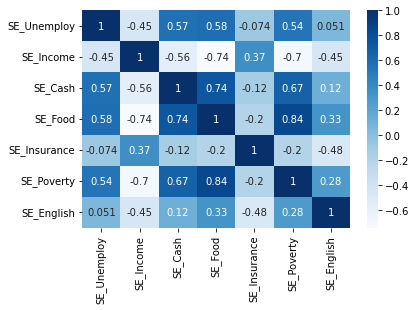

In [39]:
corr = Social_Economic.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [40]:
# strong correlation (pearson correlation > 0.5):
# unemployment: income, cash, food, poverty
# income: cash, food, poverty, english
# cash: food, poverty
# so in next step, we will using PCA combine unemployment rate, income, cash, food, and poverty as an index

In [41]:
# save file
Social_Economic.to_csv('./Data/Processed_Data/Domain/Social_Economic.csv')

## Education(E)

**E_Advance:** Population 25 years and over who has Bachelor's degree or higher

**E_PreS:** Population 3 to 4 years olds enrolled in school

**E_HighS:** Population 15 to 17 year olds enrolled in school


**Data Source:** ACS 5 years estimate

https://data.census.gov/cedsci/table?g=0500000US36005%241400000,36047%241400000,36061%241400000,36081%241400000,36085%241400000

**Geography:** Census Tract

**Date:** 2019

In [42]:
higherEDU = pd.read_csv('./Data/Raw_Data/Education/ACSST5Y2019.S1501_2022-03-13T140446/ACSST5Y2019.S1501_data_with_overlays_2022-02-15T165745.csv'
           ,skiprows=1
           ,usecols=['id'
                     #,'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over'
                     ,'Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor\'s degree or higher'
                    ])
higherEDU.head()

id  \
0  1400000US36005000100   
1  1400000US36005000200   
2  1400000US36005000400   
3  1400000US36005001600   
4  1400000US36005001900   

  Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher  
0                                                1.5                                                           
1                                               29.4                                                           
2                                               28.4                                                           
3                                               18.5                                                           
4                                               24.6

In [43]:
School = pd.read_csv('./Data/Raw_Data/Education/ACSST5Y2019.S1401_2022-03-13T221441/ACSST5Y2019.S1401_data_with_overlays_2022-03-13T141709.csv'
                    ,skiprows=1
                    ,usecols=['Estimate!!Percent!!Population 3 to 4 years!!3 to 4 year olds enrolled in school'
                              ,'id'
                              ,'Estimate!!Percent!!Population 15 to 17!!15 to 17 year olds enrolled in school'])

School.head()

id  \
0  1400000US36005000100   
1  1400000US36005000200   
2  1400000US36005000400   
3  1400000US36005001600   
4  1400000US36005001900   

  Estimate!!Percent!!Population 3 to 4 years!!3 to 4 year olds enrolled in school  \
0                                                  -                                
1                                               29.9                                
2                                               53.1                                
3                                               76.6                                
4                                               25.3                                

  Estimate!!Percent!!Population 15 to 17!!15 to 17 year olds enrolled in school  
0                                                0.0                             
1                                              100.0                             
2                                              100.0                             
3                                               90.6                             
4                                               93.6

In [44]:
Education = pd.merge(higherEDU, School)
Education = Education.rename(columns={'Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor\'s degree or higher':'E_Advance'
                                     ,'Estimate!!Percent!!Population 3 to 4 years!!3 to 4 year olds enrolled in school':'E_PreS'
                                      ,'Estimate!!Percent!!Population 15 to 17!!15 to 17 year olds enrolled in school':'E_HighS'
                                      ,'id':'GeoID'
                                     })

Education['GeoID'] = Education['GeoID'].map(lambda x: x.split('US',1)[1]).astype('int')
Education = Education.set_index('GeoID')
Education

E_Advance E_PreS E_HighS
GeoID                               
36005000100       1.5      -     0.0
36005000200      29.4   29.9   100.0
36005000400      28.4   53.1   100.0
36005001600      18.5   76.6    90.6
36005001900      24.6   25.3    93.6
...               ...    ...     ...
36085030302      30.1   83.7    89.1
36085031901      16.7    0.0   100.0
36085031902      27.2   32.4   100.0
36085032300      19.5  100.0   100.0
36085990100         -      -       -

[2167 rows x 3 columns]

In [45]:
# sanity check
Education = Education.replace({'-':np.nan}).dropna()
Education = Education.astype('float')
len(Education)

2019

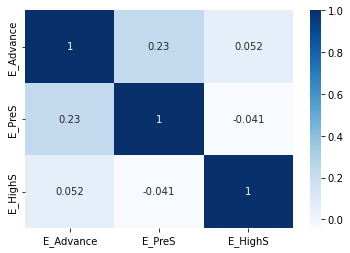

In [46]:
corr = Education.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [47]:
# save file
Education.to_csv('./Data/Processed_Data/Domain/Education.csv')

## Natural Environment (NE)
**NE_Tem:** Typical summer day surface temperature

**NE_PM25:** PM2.5 levels in air, µg/m3 annual avg.

**NE_Ozone:** Ozone summer seasonal avg. of daily maximum 8-hour concentration in air in parts per billion

### Surface Temperature

**Description:** Mean census tract-wide provisional surface temperature on typical summer day, Aug 30, 2019

**Geography:** 30-meter x 30-meter raster, aggregated to census tract

**Date:** Captured Aug 30, 2019

**Sources:** NOAA Climate Data Online, USGS Landsat Level 2 Surface Temperature Science Product/Landsat Analysis Ready Data (ARD) bundle
https://earthexplorer.usgs.gov/

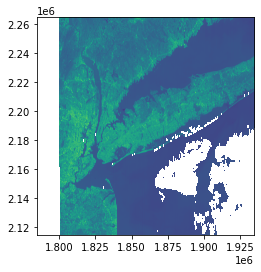

<AxesSubplot:>

In [48]:
# read surface temperature raster data
st = rasterio.open('./Data/Raw_Data/Environment/LC08_CU_029007_20190830_20190919_C01_V01_ST/LC08_CU_029007_20190830_20190919_C01_V01_ST.tif'
                   , mode='r')
show(st)

In [49]:
# read census tract data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson', driver='GeoJSON')
ct2010.head()

boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0         5    5000900  Staten Island          E  000900       9    SI22   
1         1    1009800      Manhattan          I  009800      98    MN19   
2         1    1010200      Manhattan          I  010200     102    MN17   
3         1    1010400      Manhattan          I  010400     104    MN17   
4         1    1011300      Manhattan          I  011300     113    MN17   

                                     ntaname  puma    shape_area   shape_leng  \
0  West New Brighton-New Brighton-St. George  3903  2.497010e+06  7729.016794   
1                    Turtle Bay-East Midtown  3808  1.906016e+06  5534.200308   
2                      Midtown-Midtown South  3807  1.860993e+06  5687.802439   
3                      Midtown-Midtown South  3807  1.864600e+06  5693.036367   
4                      Midtown-Midtown South  3807  1.890907e+06  5699.860640   

         GeoID                                           geometry  
0  36085000900  POLYGON ((-74.07921 40.64343, -74.07914 40.643...  
1  36061009800  POLYGON ((-73.96433 40.75638, -73.96479 40.755...  
2  36061010200  POLYGON ((-73.97124 40.76094, -73.97170 40.760...  
3  36061010400  POLYGON ((-73.97446 40.76229, -73.97491 40.761...  
4  36061011300  POLYGON ((-73.98412 40.75484, -73.98460 40.754...

In [50]:
# project census tract to same coordinate system
ct2010 = ct2010.to_crs(st.crs)

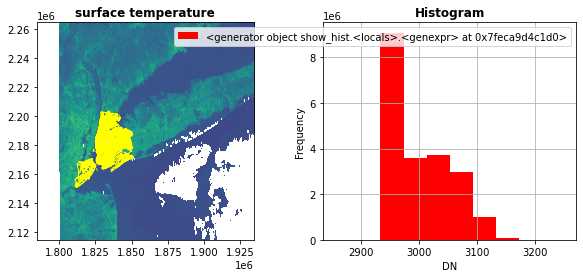

In [51]:
# plotting the raster and the census tract together
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
show(st,ax=ax1, title = 'surface temperature')
ct2010.plot(ax=ax1, facecolor='None', edgecolor='yellow')

show_hist(st, title='Histogram',ax=ax2) #Kelvins temperature (*10)
plt.show()

In [52]:
st_array = st.read(1) # assign raster values to a numpy nd array
affine = st.transform

# calculating the zonal statistics
avg_st = rasterstats.zonal_stats(ct2010,st_array, affine=affine
                                 , stats=['mean'] #max min
                                , geojson_out = True)

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [53]:
# extracting the average surface temperature from the list
avg_surfaceT = []
i = 0
while i< len(avg_st):
    avg_surfaceT.append(avg_st[i]['properties'])
    i = i+1
    
# transfering the list to pandas dataframe
avg_surfaceT = pd.DataFrame(avg_surfaceT)
avg_surfaceT.head()

GeoID boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel  \
0  36085000900         5    5000900  Staten Island          E  000900       9   
1  36061009800         1    1009800      Manhattan          I  009800      98   
2  36061010200         1    1010200      Manhattan          I  010200     102   
3  36061010400         1    1010400      Manhattan          I  010400     104   
4  36061011300         1    1011300      Manhattan          I  011300     113   

  ntacode                                    ntaname  puma    shape_area  \
0    SI22  West New Brighton-New Brighton-St. George  3903  2.497010e+06   
1    MN19                    Turtle Bay-East Midtown  3808  1.906016e+06   
2    MN17                      Midtown-Midtown South  3807  1.860993e+06   
3    MN17                      Midtown-Midtown South  3807  1.864600e+06   
4    MN17                      Midtown-Midtown South  3807  1.890907e+06   

    shape_leng         mean  
0  7729.016794  3076.366795  
1  5534.200308  3079.360406  
2  5687.802439  3050.124352  
3  5693.036367  3064.435233  
4  5699.860640  3064.309278

In [54]:
# Convert 10*Kelvin temperature to Fahrenheit
avg_surfaceT['SurfaceT_F'] = 9*(avg_surfaceT['mean']/10-273.15)/5+32
avg_surfaceT.head()

GeoID boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel  \
0  36085000900         5    5000900  Staten Island          E  000900       9   
1  36061009800         1    1009800      Manhattan          I  009800      98   
2  36061010200         1    1010200      Manhattan          I  010200     102   
3  36061010400         1    1010400      Manhattan          I  010400     104   
4  36061011300         1    1011300      Manhattan          I  011300     113   

  ntacode                                    ntaname  puma    shape_area  \
0    SI22  West New Brighton-New Brighton-St. George  3903  2.497010e+06   
1    MN19                    Turtle Bay-East Midtown  3808  1.906016e+06   
2    MN17                      Midtown-Midtown South  3807  1.860993e+06   
3    MN17                      Midtown-Midtown South  3807  1.864600e+06   
4    MN17                      Midtown-Midtown South  3807  1.890907e+06   

    shape_leng         mean  SurfaceT_F  
0  7729.016794  3076.366795   94.076023  
1  5534.200308  3079.360406   94.614873  
2  5687.802439  3050.124352   89.352383  
3  5693.036367  3064.435233   91.928342  
4  5699.860640  3064.309278   91.905670

In [55]:
avg_surfaceT = avg_surfaceT[['GeoID','SurfaceT_F']]

### PM 2.5 and Ozone

EJScreen is an environmental justice mapping and screening tool that provides EPA with a nationally consistent dataset and approach for combining environmental and demographic indicators. **EJScreen 2021 version contains 2018 PM2.5 and Ozone data**

**Data Source:** https://gaftp.epa.gov/EJSCREEN/

**Geography:** Census Tract

**Date:** 2018(EJScreen 2021)

For more information:

https://www.epa.gov/ejscreen/overview-environmental-indicators-ejscreen

https://ejscreen.epa.gov/mapper/

In [56]:
EJSCREEN = pd.read_csv('./Data/Raw_Data/Environment/EJSCREEN_2021_StatePctile_Tracts.csv', usecols=['ID','STATE_NAME','PM25','OZONE'])
EJSCREEN.head()

ID STATE_NAME      OZONE      PM25
0  1001020100    Alabama  37.010497  9.152519
1  1001020200    Alabama  37.038957  9.183280
2  1001020300    Alabama  37.069151  9.207049
3  1001020400    Alabama  37.087437  9.231752
4  1001020500    Alabama  37.123515  9.242796

In [57]:
EJSCREEN[EJSCREEN.ID.isin(HStatus.index.unique())]

ID STATE_NAME      OZONE      PM25
43283  36005000100   New York  42.154011  9.029846
43284  36005000200   New York  42.521795  8.939136
43285  36005000400   New York  42.587127  8.902753
43286  36005001600   New York  42.587327  8.949253
43287  36005001900   New York  42.051273  9.157725
...            ...        ...        ...       ...
47142  36085029104   New York  41.994270  8.828076
47143  36085030301   New York  41.961233  8.851841
47144  36085030302   New York  41.954758  8.873564
47145  36085031901   New York  41.947769  8.901235
47146  36085031902   New York  41.936524  8.923397

[1970 rows x 4 columns]

In [58]:
Environment = pd.merge(avg_surfaceT,EJSCREEN, left_on='GeoID', right_on='ID')
Environment = Environment.rename(columns={'OZONE':'NE_Ozone'
                                         ,'PM25':'NE_PM25'
                                         ,'SurfaceT_F':'NE_Tem'})

Environment = Environment.drop(columns=['ID','STATE_NAME']).set_index('GeoID')
Environment.head()

NE_Tem   NE_Ozone   NE_PM25
GeoID                                      
36085000900  94.076023  41.671695  8.968913
36061009800  94.614873  41.693379  9.237539
36061010200  89.352383  41.701241  9.244300
36061010400  91.928342  41.691546  9.259344
36061011300  91.905670  41.649439  9.262772

In [59]:
len(Environment)

2165

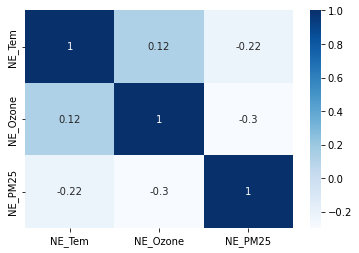

In [60]:
corr = Environment.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [61]:
# save file
Environment.to_csv('./Data/Processed_Data/Domain/Environment.csv')

## Creat 15min walk distance base map

#### Load  2010 Census Blocks 21A
Date: 2021 releases

In [96]:
cb2010 = gpd.read_file('./Data/Raw_Data/nycb2010_21a/nycb2010.shp')
cb2010.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  # two-step construction to avoid this
/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  # two-step construction to avoid this


CB2010 BoroCode       BoroName  CT2010    BCTCB2010   Shape_Leng  \
0   1000        5  Staten Island  000900  50009001000  2508.948115   
1   1000        5  Staten Island  002001  50020011000  1345.886422   
2   1000        5  Staten Island  002700  50027001000  1703.381172   
3   1000        5  Staten Island  004000  50040001000  1511.173743   
4   1000        5  Staten Island  006400  50064001000  1978.243852   

      Shape_Area                                           geometry  
0  244589.603884  POLYGON ((962269.126 173705.500, 962288.722 17...  
1  111006.286826  POLYGON ((964642.268 161835.265, 964359.942 16...  
2  150406.766022  POLYGON ((963363.117 167356.334, 962737.737 16...  
3  141296.561149  POLYGON ((960069.997 161953.694, 959831.480 16...  
4  200784.983607  POLYGON ((963023.892 158246.752, 962949.824 15...

In [97]:
cb2010.BoroName.unique()

array(['Staten Island', 'Manhattan', 'Brooklyn', 'Bronx', 'Queens'],
      dtype=object)

In [98]:
# crate cb2010 GeoID for matching data

cb2010['GeoID']=0
for i in range(len(cb2010['BoroName'])):
    if (cb2010['BoroName'][i]=='Manhattan'):
        cb2010['GeoID'][i] = '36061'+ cb2010['CT2010'][i]
    
    elif (cb2010['BoroName'][i]=='Bronx'):
        cb2010['GeoID'][i] = '36005'+ cb2010['CT2010'][i]
        
    elif (cb2010['BoroName'][i]=='Queens'):
        cb2010['GeoID'][i] = '36081'+ cb2010['CT2010'][i]
    
    elif (cb2010['BoroName'][i]=='Brooklyn'):
        cb2010['GeoID'][i] = '36047'+ cb2010['CT2010'][i]
    
    elif (cb2010['BoroName'][i]=='Staten Island'):
        cb2010['GeoID'][i] = '36085'+ cb2010['CT2010'][i]
    
    else:
        print('no')

cb2010.head()  

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import ke

CB2010 BoroCode       BoroName  CT2010    BCTCB2010   Shape_Leng  \
0   1000        5  Staten Island  000900  50009001000  2508.948115   
1   1000        5  Staten Island  002001  50020011000  1345.886422   
2   1000        5  Staten Island  002700  50027001000  1703.381172   
3   1000        5  Staten Island  004000  50040001000  1511.173743   
4   1000        5  Staten Island  006400  50064001000  1978.243852   

      Shape_Area                                           geometry  \
0  244589.603884  POLYGON ((962269.126 173705.500, 962288.722 17...   
1  111006.286826  POLYGON ((964642.268 161835.265, 964359.942 16...   
2  150406.766022  POLYGON ((963363.117 167356.334, 962737.737 16...   
3  141296.561149  POLYGON ((960069.997 161953.694, 959831.480 16...   
4  200784.983607  POLYGON ((963023.892 158246.752, 962949.824 15...   

         GeoID  
0  36085000900  
1  36085002001  
2  36085002700  
3  36085004000  
4  36085006400

In [99]:
# check data
len(cb2010.GeoID.unique())

2165

In [100]:
len(ct2010)

2165

In [105]:
# save this geo file
cb2010.to_file('./Data/Processed_Data/cb2010_geoid.geojson', driver='GeoJSON')

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  will determine the schema based on each column's dtype


In [106]:
# make sure crs = 2263
cb2010.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [107]:
# generate block centre point as our demand node
cb2010_Point = cb2010[['GeoID','BCTCB2010']]
cb2010_Point['geometry'] = cb2010.representative_point()
cb2010_Point = gpd.GeoDataFrame(cb2010_Point, geometry=cb2010_Point['geometry'],crs=2263)
cb2010_Point.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


GeoID    BCTCB2010                       geometry
0  36085000900  50009001000  POINT (962011.056 173889.721)
1  36085002001  50020011000  POINT (964403.556 161849.667)
2  36085002700  50027001000  POINT (963018.590 167447.662)
3  36085004000  50040001000  POINT (959815.570 161897.555)
4  36085006400  50064001000  POINT (962618.080 158184.976)

In [108]:
cb2010_Point.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [109]:
# creat 4224 ft (0.8 mile) buffer
cb2010_Buffer = cb2010_Point.copy()
cb2010_Buffer['geometry'] = cb2010_Point.buffer(distance=4224)
cb2010_Buffer.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  return out
/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  # two-step construction to avoid this


GeoID    BCTCB2010                                           geometry
0  36085000900  50009001000  POLYGON ((966235.056 173889.721, 966214.716 17...
1  36085002001  50020011000  POLYGON ((968627.556 161849.667, 968607.216 16...
2  36085002700  50027001000  POLYGON ((967242.590 167447.662, 967222.250 16...
3  36085004000  50040001000  POLYGON ((964039.570 161897.555, 964019.230 16...
4  36085006400  50064001000  POLYGON ((966842.080 158184.976, 966821.740 15...

In [110]:
# save this geo file
cb2010_Buffer.to_file('./Data/Processed_Data/cb2010_Buffer.geojson', driver='GeoJSON')

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  will determine the schema based on each column's dtype


## Neighborhood (N)
**N_TreeD:** Trees density (trees per acre)

**N_LandUseMix:** Land-Use mix of commercial, residential (Employment and household entropy)

**N_Park:** Area(arce) of parks within 15 min walk distance (0.8 mile)

**N_HFood:** Numbers of supermarkets within 15 min walk distance (0.8 mile)

### N_TreeD: Trees Density

**Data Source:** Forestry Tree Points (Department of Parks and Recreation (DPR))

https://data.cityofnewyork.us/Environment/Forestry-Tree-Points/k5ta-2trh

**Geography:** Point/census tract

**Date:** Updated May 1, 2022

In [5]:
Tree = pd.read_csv('./Data/Raw_Data/Built_Environment/Forestry_Tree_Points.csv')
Tree.head()

OBJECTID   DBH TPStructure TPCondition  StumpDiameter  \
0   2249468  26.0        Full        Good            0.0   
1   4609412   3.0     Retired   Excellent            NaN   
2   1405530  30.0        Full        Fair            NaN   
3   4607742   3.0     Retired   Excellent            NaN   
4   2110343   5.0        Full        Good            0.0   

                  PlantingSpaceGlobalID  \
0  EE298162-61DE-4326-94CF-BAEADF67BBD2   
1                                   NaN   
2  A3006528-1BB5-4B0D-AD98-31ABC173385A   
3  0C566EE4-669C-48F7-BDDD-FDE286065202   
4  9C8DB8A7-7437-4087-8F45-F76F4770CC54   

                                        Geometry  \
0  POINT (1010086.2170835584 253833.11250019073)   
1                                            NaN   
2  POINT (1030435.7016668916 198098.22812518477)   
3    POINT (990456.88625022769 180979.589375183)   
4    POINT (982157.3310419023 204286.6170835197)   

                               GlobalID                       GenusSpecies  \
0  3CB519D4-82D6-4BF2-A893-F61C36D79D97        Quercus palustris - pin oak   
1  7E64FD63-8FBF-4B6C-8E42-73CD6F965000  Quercus shumardii - Shumard's oak   
2  7AFC77DE-E6D9-4B4F-9C74-35B1C7581A90        Quercus palustris - pin oak   
3  C8D2B5C9-B418-46BB-9F55-4F0F359D7F8C   Quercus imbricaria - shingle oak   
4  603AE884-99BF-4D3D-978A-8C2BFF15044D       Quercus phellos - willow oak   

              CreatedDate             UpdatedDate             PlantedDate  \
0  01/05/2016 04:09:01 PM  10/18/2019 06:30:11 PM                     NaN   
1  10/27/2016 11:11:00 AM  09/04/2019 05:31:46 PM  06/28/2016 04:00:00 AM   
2  10/29/2015 01:16:28 PM  10/02/2019 05:46:25 PM                     NaN   
3  10/27/2016 11:11:00 AM  01/15/2019 03:25:00 PM                     NaN   
4  01/05/2016 12:09:12 PM  10/28/2019 01:15:14 PM                     NaN   

   RiskRating          RiskRatingDate                                 Location  
0         7.0  10/18/2019 06:30:11 PM  (40.86335012718705, -73.90659403804088)  
1         NaN                     NaN                                      NaN  
2         8.0  10/02/2019 05:46:25 PM  (40.71029008261361, -73.83340766957191)  
3         NaN                     NaN  (40.66342171188454, -73.97762743738365)  
4         3.0  10/28/2019 01:15:14 PM  (40.72739601895657, -74.00755021282579)

In [7]:
Tree = Tree[Tree.TPStructure == 'Full']
Tree = Tree.dropna(subset=['Geometry'],axis=0)
Tree = Tree[['OBJECTID','Geometry']]
Tree.head()

OBJECTID                                       Geometry
0   2249468  POINT (1010086.2170835584 253833.11250019073)
2   1405530  POINT (1030435.7016668916 198098.22812518477)
4   2110343    POINT (982157.3310419023 204286.6170835197)
5   1039124  POINT (999867.84375022352 235730.29937517643)
6   4610785  POINT (945746.78562523425 146254.77000018954)

In [8]:
from shapely import wkt
Tree['geometry'] = Tree['Geometry'].apply(wkt.loads)

In [9]:
TreeGeo = gpd.GeoDataFrame(Tree, geometry=Tree['geometry'], crs=2263)

In [10]:
# read census tract data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson', driver='GeoJSON').to_crs(2263)
ct2010.head()

boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0         5    5000900  Staten Island          E  000900       9    SI22   
1         1    1009800      Manhattan          I  009800      98    MN19   
2         1    1010200      Manhattan          I  010200     102    MN17   
3         1    1010400      Manhattan          I  010400     104    MN17   
4         1    1011300      Manhattan          I  011300     113    MN17   

                                     ntaname  puma    shape_area   shape_leng  \
0  West New Brighton-New Brighton-St. George  3903  2.497010e+06  7729.016794   
1                    Turtle Bay-East Midtown  3808  1.906016e+06  5534.200308   
2                      Midtown-Midtown South  3807  1.860993e+06  5687.802439   
3                      Midtown-Midtown South  3807  1.864600e+06  5693.036367   
4                      Midtown-Midtown South  3807  1.890907e+06  5699.860640   

         GeoID                                           geometry  
0  36085000900  POLYGON ((962269.126 173705.500, 962288.722 17...  
1  36061009800  POLYGON ((994133.507 214848.898, 994005.909 21...  
2  36061010200  POLYGON ((992216.539 216507.687, 992091.031 21...  
3  36061010400  POLYGON ((991325.882 217001.689, 991199.221 21...  
4  36061011300  POLYGON ((988650.277 214286.402, 988517.806 21...

In [11]:
ct2010.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
TreeGeo.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
# spatial join with census tract
Tree_ct = gpd.sjoin(TreeGeo, ct2010, how="inner", op='intersects')
Tree_ct.head()

OBJECTID                                       Geometry  \
0     2249468  POINT (1010086.2170835584 253833.11250019073)   
312   5104973  POINT (1009500.0583335608 253667.02791684866)   
462   5028956  POINT (1009945.0377085656 253748.57708351314)   
629   5108474  POINT (1009724.1468752325 253702.27604185045)   
705   2249472  POINT (1010256.8141668886 253899.32125018537)   

                           geometry  index_right boro_code boro_ct201  \
0    POINT (1010086.217 253833.113)          892         2    2026300   
312  POINT (1009500.058 253667.028)          892         2    2026300   
462  POINT (1009945.038 253748.577)          892         2    2026300   
629  POINT (1009724.147 253702.276)          892         2    2026300   
705  POINT (1010256.814 253899.321)          892         2    2026300   

    boro_name cdeligibil  ct2010 ctlabel ntacode              ntaname  puma  \
0       Bronx          E  026300     263    BX30  Kingsbridge Heights  3706   
312     Bronx          E  026300     263    BX30  Kingsbridge Heights  3706   
462     Bronx          E  026300     263    BX30  Kingsbridge Heights  3706   
629     Bronx          E  026300     263    BX30  Kingsbridge Heights  3706   
705     Bronx          E  026300     263    BX30  Kingsbridge Heights  3706   

       shape_area   shape_leng        GeoID  
0    1.715401e+06  7522.471935  36005026300  
312  1.715401e+06  7522.471935  36005026300  
462  1.715401e+06  7522.471935  36005026300  
629  1.715401e+06  7522.471935  36005026300  
705  1.715401e+06  7522.471935  36005026300

In [25]:
Tree_ct_geo = Tree_ct.groupby('GeoID').agg({'OBJECTID':'count'}).merge(ct2010[['GeoID','shape_area']], left_index=True, right_on='GeoID')
Tree_ct_geo.head()

OBJECTID        GeoID    shape_area
2157       518  36005000200  5.009780e+06
1374       932  36005000400  8.557953e+06
994        530  36005001600  5.221330e+06
1945       589  36005001900  1.796100e+07
1060       504  36005002000  4.336906e+06

In [26]:
Tree_ct_geo.describe()

OBJECTID         GeoID    shape_area
count   2158.000000  2.158000e+03  2.158000e+03
mean     392.970343  3.605477e+10  3.863641e+06
std      526.847116  2.593549e+07  7.909182e+06
min        2.000000  3.600500e+10  4.478077e+05
25%      192.000000  3.604703e+10  1.683716e+06
50%      265.000000  3.604712e+10  1.986588e+06
75%      402.750000  3.608103e+10  3.154124e+06
max    13437.000000  3.608503e+10  1.966544e+08

In [27]:
Tree_ct_geo['N_TreeD'] = Tree_ct_geo['OBJECTID']/(Tree_ct_geo['shape_area']/43560) # 1 acre equals 43560 square feet
N_TreeD = Tree_ct_geo[['N_TreeD','GeoID']]
N_TreeD.head()

N_TreeD        GeoID
2157  4.504006  36005000200
1374  4.743882  36005000400
994   4.421632  36005001600
1945  1.428475  36005001900
1060  5.062189  36005002000

In [51]:
len(N_TreeD)

2158

In [30]:
# save file
N_TreeD.to_csv('./Data/Processed_Data/Domain/Neighborhood/N_TreeD.csv')

### N_HFood:  
**Description:** Numbers of supermarkets within 15 min walk distance (0.8 mile)

**Method:** Calculate the number of supermarkets within 0.8 miles of the census block's centroid, then average the census block values that correspond to the census tract .

**Data Source:** OpenStreetMap(OSM) via osmnx library

**Geography:** Point/census block/census tract

**Date:** 2022

**Reference:** *Zaccaro, H. (2019). Blind Spots: How Unhealthy Corridors Harm Communities and how to Fix Them.*

In [44]:
place = 'New York, USA'
tags = {'landuse':'retail'} #specify the amenity type
supermarket = ox.geometries_from_place(place, tags=tags)
supermarket.head()

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


geometry  \
element_type osmid                                                           
node         2569476489                         POINT (-73.91475 40.63418)   
             2576246034                         POINT (-73.98581 40.74655)   
             2681968140                         POINT (-73.98764 40.74459)   
way          32197924    POLYGON ((-73.71336 40.66316, -73.71310 40.663...   
             34900284    POLYGON ((-74.16575 40.58605, -74.16569 40.586...   

                        source addr:city addr:housenumber addr:postcode  \
element_type osmid                                                        
node         2569476489    NaN  Brooklyn             7718         11236   
             2576246034    NaN  New York              303         10016   
             2681968140    NaN  New York              244         10001   
way          32197924      NaN       NaN              NaN           NaN   
             34900284      NaN       NaN              NaN           NaN   

                              addr:street landuse                 name  \
element_type osmid                                                       
node         2569476489  Flatlands Avenue  retail          TVandNav2Go   
             2576246034        5th Avenue  retail       Paramount Rugs   
             2681968140        5th Avenue  retail  MaryJane Hemp Foods   
way          32197924                 NaN  retail     Green Acres Mall   
             34900284                 NaN  retail   Staten Island Mall   

                                                                      note  \
element_type osmid                                                           
node         2569476489  TVandNav2Go specializes in converting OEM navi...   
             2576246034                                                NaN   
             2681968140                                                NaN   
way          32197924                                                  NaN   
             34900284                                                  NaN   

                        payment:bitcoin            phone  \
element_type osmid                                         
node         2569476489             yes  +1 718 763-7367   
             2576246034             yes    +1 2124330127   
             2681968140             yes  +1 212 401 0708   
way          32197924               NaN              NaN   
             34900284               NaN              NaN   

                        service:vehicle:electrical        shop  \
element_type osmid                                               
node         2569476489                        yes  car_repair   
             2576246034                        NaN         NaN   
             2681968140                        NaN         NaN   
way          32197924                          NaN         NaN   
             34900284                          NaN         NaN   

                                                    website  \
element_type osmid                                            
node         2569476489             http://tvandnav2go.com/   
             2576246034          https://paramountrugs.com/   
             2681968140      https://maryjanehempfoods.com/   
way          32197924                                   NaN   
             34900284    https://www.statenisland-mall.com/   

                                                                     nodes  \
element_type osmid                                                           
node         2569476489                                                NaN   
             2576246034                                                NaN   
             2681968140                                                NaN   
way          32197924    [2765941804, 4497127181, 361086223, 4497144332...   
             34900284    [409376886, 8282286482, 8282286481, 8282286480...   

                        internet_access internet_acces

In [45]:
len(supermarket)

125

In [32]:
supermarket = supermarket[supermarket.geom_type == 'Point'].reset_index()[['shop','geometry']]
supermarket.head()

shop                    geometry
0  supermarket  POINT (-73.96646 40.68704)
1  supermarket  POINT (-73.82535 40.74343)
2  supermarket  POINT (-73.86297 40.82728)
3  supermarket  POINT (-73.81411 40.72842)
4  supermarket  POINT (-73.80451 40.73331)

In [33]:
supermarket.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
supermarket = supermarket.to_crs(2263)
supermarket.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [144]:
# spatial join with cb2010_Buffer
BE_HFood = gpd.sjoin(supermarket, cb2010_Buffer, how="right", op='intersects')
BE_HFood = BE_HFood.groupby('BCTCB2010').agg({'shop':'count','GeoID':'mean'})
BE_HFood['GeoID'] = BE_HFood['GeoID'].astype('int')
BE_HFood.head()

shop        GeoID
BCTCB2010                     
10001001000     0  36061000100
10001001001     0  36061000100
10002011000    31  36061000201
10002011001    33  36061000201
10002012000    29  36061000201

In [145]:
BE_HFood = BE_HFood.groupby('GeoID').agg({'shop':'mean'}).reset_index().rename(columns={'shop':'BE_HFood'})
BE_HFood.head()

GeoID  BE_HFood
0  36005000100  0.000000
1  36005000200  0.000000
2  36005000400  0.000000
3  36005001600  1.000000
4  36005001900  1.107527

In [146]:
# save file
BE_HFood.to_csv("./Data/Processed_Data/BE_HFood.csv")

### N_Park:  
**Description:** Area(arce) of parks within 15 min walk distance (0.8 mile)

**Method:** Calculate the total area of parks within 0.8 miles of the census block's centroid, then average the census block values that correspond to the census tract .

**Data Source:** OpenStreetMap(OSM) via osmnx library

**Geography:** Polygon/census block/census tract

**Date:** 2022

In [10]:
place = 'New York, USA'
tags = {'leisure':'park'} 
park = ox.geometries_from_place(place, tags=tags)
park.head()

unique_id      osmid element_type highway                    geometry  \
0  node/357545993  357545993         node     NaN  POINT (-73.91403 40.87316)   
1  node/357558856  357558856         node     NaN  POINT (-73.91014 40.88177)   
2  node/357562455  357562455         node     NaN  POINT (-74.12625 40.54816)   
3  node/357563150  357563150         node     NaN  POINT (-73.83958 40.87343)   
4  node/357564243  357564243         node     NaN  POINT (-74.08736 40.63038)   

  barrier              name operator man_made ele gnis:county_id gnis:created  \
0     NaN       Baker Field      NaN      NaN  17            061   01/23/1980   
1     NaN         Ewen Park      NaN      NaN  21            005   01/23/1980   
2     NaN  Great Kills Park      NaN      NaN   6            085   01/23/1980   
3     NaN       Haffen Park      NaN      NaN  15            005   01/23/1980   
4     NaN         Hero Park      NaN      NaN  77            085   01/23/1980   

  gnis:feature_id gnis:state_id leisure   wikidata gnis:edited heritage  \
0          942830            36    park  Q34804359         NaN      NaN   
1          949783            36    park        NaN         NaN      NaN   
2          951634            36    park        NaN         NaN      NaN   
3          951981            36    park        NaN         NaN      NaN   
4          952631            36    park        NaN         NaN      NaN   

  heritage:operator heritage:website historic nrhp:criteria  \
0               NaN              NaN      NaN           NaN   
1               NaN              NaN      NaN           NaN   
2               NaN              NaN      NaN           NaN   
3               NaN              NaN      NaN           NaN   
4               NaN              NaN      NaN           NaN   

  nrhp:inscription_date ref:nrhp source_ref opening_hours website addr:street  \
0                   NaN      NaN        NaN           NaN     NaN         NaN   
1                   NaN      NaN        NaN           NaN     NaN         NaN   
2                   NaN      NaN        NaN           NaN     NaN         NaN   
3                   NaN      NaN        NaN           NaN     NaN         NaN   
4                   NaN      NaN        NaN           NaN     NaN         NaN   

  start_date wikipedia operator:type operator:wikidata operator:wikipedia  \
0        NaN       NaN           NaN               NaN                NaN   
1        NaN       NaN           NaN               NaN                NaN   
2        NaN       NaN           NaN               NaN                NaN   
3        NaN       NaN           NaN               NaN                NaN   
4        NaN       NaN           NaN               NaN                NaN   

  source  ref name:es tourism level access bicycle addr:city addr:postcode  \
0    NaN  NaN     NaN     NaN   NaN    NaN     NaN       NaN           NaN   
1    NaN  NaN     NaN     NaN   NaN    NaN     NaN       NaN           NaN   
2    NaN  NaN     NaN     NaN   NaN    NaN     NaN       NaN           NaN   
3    NaN  NaN     NaN     NaN   NaN    NaN     NaN       NaN           NaN   
4    NaN  NaN     NaN     NaN   NaN    NaN     NaN       NaN           NaN   

  addr:housenumber material operator:short  lit wheelchair addr:state note  \
0              NaN      NaN            NaN  NaN        NaN        NaN  NaN   
1              NaN      NaN            NaN  NaN        NaN        NaN  NaN   
2              NaN      NaN            NaN  NaN        NaN        NaN  NaN   
3              NaN      NaN            NaN  NaN        NaN        NaN  NaN   
4              NaN      NaN            NaN  NaN        NaN        NaN  NaN   

  phone natural description layer covered fixme sport garden:type nodes  \
0   NaN     NaN         NaN   NaN     NaN   NaN   NaN         NaN   NaN   
1   NaN     NaN         NaN   NaN     NaN   NaN   NaN         NaN   NaN   
2   NaN     NaN         NaN   NaN     NaN   NaN   NaN         NaN   NaN   
3   NaN     NaN 

In [11]:
park = park[(park.geom_type == 'Polygon')|(park.geom_type == 'MultiPolygon')].reset_index()[['name','geometry']].to_crs(2263)
park

name  \
0                        Battery Park   
1                   Cadman Plaza Park   
2                    Fort Greene Park   
3                       Columbus Park   
4           Korean War Veterans Plaza   
...                               ...   
1679                 Bella Abzug Park   
1680                    McCarren Park   
1681                    Red Hook Park   
1682  Colonel David Marcus Playground   
1683              Crescent Beach Park   

                                               geometry  
0     POLYGON ((979507.536 196051.889, 979502.458 19...  
1     POLYGON ((986982.303 193027.461, 987064.827 19...  
2     POLYGON ((991374.296 191816.446, 991373.148 19...  
3     POLYGON ((986956.240 191999.575, 986865.283 19...  
4     POLYGON ((986947.547 192877.171, 986960.941 19...  
...                                                 ...  
1679  MULTIPOLYGON (((983788.791 214303.804, 983894....  
1680  MULTIPOLYGON (((996739.322 202425.356, 997064....  
1681  MULTIPOLYGON (((983030.064 184685.623, 983482....  
1682  MULTIPOLYGON (((992450.428 161450.258, 992525....  
1683  MULTIPOLYGON (((942839.963 134197.115, 942894....  

[1684 rows x 2 columns]

In [12]:
park.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
cb2010_Buffer = gpd.read_file('./Data/Processed_Data/cb2010_Buffer.geojson')

/Users/taoliang/opt/anaconda3/envs/HCI/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [14]:
# boolean operation
N_Park = gpd.overlay(cb2010_Buffer, park, how='intersection')

/Users/taoliang/opt/anaconda3/envs/HCI/lib/python3.7/site-packages/geopandas/_vectorized.py:304: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for this_elem, other_elem in zip(left, right)
/Users/taoliang/opt/anaconda3/envs/HCI/lib/python3.7/site-packages/geopandas/_vectorized.py:304: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  for this_elem, other_elem in zip(left, right)
/Users/taoliang/opt/anaconda3/envs/HCI/lib/python3.7/site-packages/geopandas/

KeyboardInterrupt: 

In [ ]:
N_Park['N_Park'] = N_Park.area/43560 # 1 acre equals 43560 square feet
N_Park.head()

In [77]:
BE_Park['BE_Park'] = BE_Park.area/43560 # 1 acre equals 43560 square feet
BE_Park.head()

GeoID    BCTCB2010                        name  \
0  36085000900  50009001000  Nicholas Lia Memorial Park   
1  36085007500  50075001000  Nicholas Lia Memorial Park   
2  36085007700  50077001000  Nicholas Lia Memorial Park   
3  36085000900  50009001001  Nicholas Lia Memorial Park   
4  36085001100  50011001001  Nicholas Lia Memorial Park   

                                            geometry   BE_Park  
0  POLYGON ((962121.696 173913.124, 962200.943 17...  1.305141  
1  POLYGON ((962121.696 173913.124, 962200.943 17...  1.305141  
2  POLYGON ((962121.696 173913.124, 962200.943 17...  1.305141  
3  POLYGON ((962121.696 173913.124, 962200.943 17...  1.305141  
4  POLYGON ((962121.696 173913.124, 962200.943 17...  1.305141

In [78]:
BE_Park = BE_Park.groupby('BCTCB2010').agg({'BE_Park':'sum','GeoID':'mean'})
BE_Park['GeoID'] = BE_Park['GeoID'].astype('int')
BE_Park.head()

BE_Park        GeoID
BCTCB2010                          
10001001000  41.675515  36061000100
10001001001  41.572781  36061000100
10002011000  92.115029  36061000201
10002011001  90.548518  36061000201
10002012000  89.156724  36061000201

In [79]:
BE_Park = BE_Park.groupby('GeoID').agg({'BE_Park':'mean'}).reset_index()
BE_Park.head()

GeoID     BE_Park
0  36005000100    3.607041
1  36005000200  117.919240
2  36005000400   81.596888
3  36005001600  142.340526
4  36005001900  149.885542

In [80]:
BE_Park.describe()

GeoID      BE_Park
count  2.165000e+03  2165.000000
mean   3.605475e+10    98.125953
std    2.595373e+07   108.549134
min    3.600500e+10     0.977895
25%    3.604703e+10    23.685854
50%    3.604712e+10    54.780130
75%    3.608103e+10   134.545455
max    3.608599e+10   797.281378

In [81]:
# save file
BE_Park.to_csv("./Data/Processed_Data/BE_Park.csv")

### BE_LandUseMix: 

**Description:** Land-Use mix of commercial, residential (Employment and household entropy)

**Data Source:** SmartLocationDatabaseV3

https://www.epa.gov/smartgrowth/smart-location-mapping#SLD

**Geography:** Census Block/Census Tract
**Date:** 2021

In [183]:
# data at block level
SLD = gpd.read_file('./Data/Raw_Data/Built_Environment/SmartLocationDatabaseV3/SmartLocationData.shp')
SLD.head()

OBJECTID       GEOID10       GEOID20 STATEFP COUNTYFP TRACTCE BLKGRPCE  \
0       1.0  481130078254  481130078254      48      113  007825        4   
1       2.0  481130078252  481130078252      48      113  007825        2   
2       3.0  481130078253  481130078253      48      113  007825        3   
3       4.0  481130078241  481130078241      48      113  007824        1   
4       5.0  481130078242  481130078242      48      113  007824        2   

   CSA                  CSA_Name   CBSA                        CBSA_Name  \
0  206  Dallas-Fort Worth, TX-OK  19100  Dallas-Fort Worth-Arlington, TX   
1  206  Dallas-Fort Worth, TX-OK  19100  Dallas-Fort Worth-Arlington, TX   
2  206  Dallas-Fort Worth, TX-OK  19100  Dallas-Fort Worth-Arlington, TX   
3  206  Dallas-Fort Worth, TX-OK  19100  Dallas-Fort Worth-Arlington, TX   
4  206  Dallas-Fort Worth, TX-OK  19100  Dallas-Fort Worth-Arlington, TX   

    CBSA_POP   CBSA_EMP   CBSA_WRK    Ac_Total  Ac_Water     Ac_Land  \
0  7189384.0  3545715.0  3364458.0   73.595028       0.0   73.595028   
1  7189384.0  3545715.0  3364458.0  119.829909       0.0  119.829909   
2  7189384.0  3545715.0  3364458.0   26.367053       0.0   26.367053   
3  7189384.0  3545715.0  3364458.0  119.060687       0.0  119.060687   
4  7189384.0  3545715.0  3364458.0  169.927211       0.0  169.927211   

      Ac_Unpr  TotPop  CountHU     HH  P_WrkAge  AutoOwn0   Pct_AO0  AutoOwn1  \
0   73.595028    1202    460.0  423.0     0.549        69  0.163121        39   
1  119.214200     710    409.0  409.0     0.466         0  0.000000       168   
2   26.367050     737    365.0  329.0     0.811        19  0.057751       143   
3  119.060687     904    384.0  384.0     0.638         0  0.000000        43   
4  148.742920     948    343.0  343.0     0.506         5  0.014577        67   

    Pct_AO1  AutoOwn2p  Pct_AO2p  Workers  R_LowWageW  R_MedWageW  R_HiWageWk  \
0  0.092199        315  0.744681      412          99         122         191   
1  0.410758        241  0.589242      395          76         107         212   
2  0.434650        167  0.507599      463         136         189         138   
3  0.111979        341  0.888021      431          60          69         302   
4  0.195335        271  0.790087      579          91          84         404   

   R_PCTLOWWA  TotEmp  E5_Ret  E5_Off  E5_Ind  E5_Svc  E5_Ent  E8_Ret  E8_off  \
0    0.240291      66      20       3       0      19      24      20       3   
1    0.192405      25       7       0       3      15       0       7       0   
2    0.293737       0       0       0       0       0       0       0       0   
3    0.139211     253      26       0      25      47     155      26       0   
4    0.157168      32       0       2      10      20       0       0       2   

   E8_Ind  E8_Svc  E8_Ent  E8_Ed  E8_Hlth  E8_Pub  E_LowWageW  E_MedWageW  \
0       0      15      24      0        4       0          21          27   
1       3      13       0      0        2       0          10           4   
2       0       0       0      0        0       0           0           0   
3      25       3     155      2       42       0         121          87   
4      10      19       0      0        1       0           6           9   

   E_HiWageWk  E_PctLowWa        D1A        D1B       D1C  D1C5_RET  D1C5_OFF  \
0          18    0.318182   6.250422  16.332625  0.896800  0.271757  0.040764   
1          11    0.400000   3.430799   5.955666  0.209707  0.058718  0.000000   
2           0    0.000000  13.843035  27.951553  0.000000  0.000000  0.000000   
3          45    0.478261   3.225246   7.592767  2.124967  0.218376  0.000000   
4          17    0.187500   2.305992   6.373413  0.215136  0.000000  0.013446   

   D1C5_IND  D1C5_SVC  D1C5_ENT  D1C8_RET  D1C8_OFF  D1C8_IND  D1C8_SVC  \
0  0.000000  0.258170  0.326109  0.271757  0.040764  0.000000  0.203818   
1  0.025165  0.125824  0.000000  0.058718  0.000000  0.025165  0.109047   
2  0.000000  0

In [186]:
SLDNY = SLD[['GEOID10','D2A_EPHHM']]
SLDNY['GEOID10'] = SLDNY['GEOID10'].astype('str')
SLDNY['GeoID'] = SLDNY['GEOID10'].str[:-1]
SLDNY['GeoID'] = SLDNY['GeoID'].astype('int')
SLDNY = SLDNY[SLDNY.GeoID.isin(ct2010.GeoID)]
SLDNY.head()

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

GEOID10  D2A_EPHHM        GeoID
148836  360810259002   0.813842  36081025900
148837  360810166002   0.449212  36081016600
148838  360811227021   0.000000  36081122702
148839  360810283005   0.320219  36081028300
148840  360811483004   0.626858  36081148300

In [191]:
BE_LandUseMix = SLDNY.groupby('GeoID').agg({'D2A_EPHHM':'mean'}).rename(columns={'D2A_EPHHM':'BE_LandUseMix'})

In [192]:
# save file
BE_LandUseMix.to_csv("./Data/Processed_Data/BE_LandUseMix.csv")

## Transportation

**BE_WalkVSDrive:** The area of sidewalks divided by the sum of the area of the roadway segment and the area sidewalks in a given census tract

**BE_Transit:** Numbers of Transits(train, subway, bus, or ferry stop.) within 15 min walk distance (0.8 mile)

**BE_nodeD:** Intersection density in terms of pedestrian-oriented intersections.(number of intersection per acre)

### BE_WalkVSDrive:  
**Description:** The area of sidewalks divided by the sum of the area of the roadway segment and the area sidewalks in a given census tract

**Method:** Spatial Boolean operations were performed to extract all sidewalks and roads within the census tract and then calculate the area respectively. Finally, the area of the sidewalk was divided by the area of the road. This method allows an indirect representation of the sidewalk width. 

$ BE\_WalkVSDrive = \frac{area_{sidewalks}}{area_{sidewalks} + area_{roadway}} $ 


    
**Data Source:** \
Sidewalk (DoITT) https://data.cityofnewyork.us/City-Government/Sidewalk/vfx9-tbb6 \
LION 21A https://www1.nyc.gov/site/planning/data-maps/open-data/bytes-archive.page?sorts[year]=0

**Geography:** Polygon, LineString/census tract

**Date:** \
sidewalk (September 13, 2018)\
LION 21A (2021)


#### Demo: How to perform Boolean operations on line segments and shapely

In [214]:
line_list = [LineString([[0,0], [1,2]])]
poly_list = [Polygon([[0, 0], [1, 0], [1, 1], [0, 1]]), Polygon([[0.5, 1.5], [1.5, 1.5], [1.5, 2], [0.5, 2]])]

lines_gdf = gpd.GeoDataFrame(geometry=line_list)
polys_gdf = gpd.GeoDataFrame(geometry=poly_list)

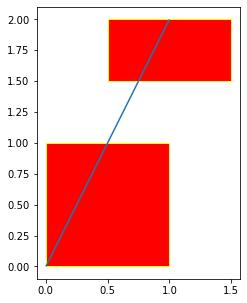

In [215]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
polys_gdf.plot(ax=ax,facecolor='r', edgecolor='yellow' )
lines_gdf.plot(ax=ax)
plt.show()

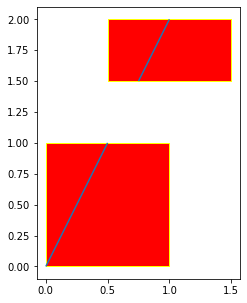

In [216]:
# boolean linestring with shapely
fig, ax = plt.subplots(1,1, figsize=(5,5))
polys_gdf.plot(ax=ax,facecolor='r', edgecolor='yellow' )
gpd.overlay(lines_gdf, polys_gdf, how='intersection').plot(ax=ax) 
plt.show()

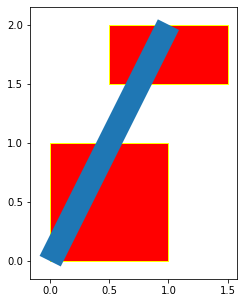

In [217]:
buffer_gdf = gpd.GeoDataFrame(geometry=lines_gdf.buffer(distance=0.1, cap_style=2))

fig, ax = plt.subplots(1,1, figsize=(5,5))
polys_gdf.plot(ax=ax,facecolor='r', edgecolor='yellow' )
buffer_gdf.plot(ax=ax)
plt.show()

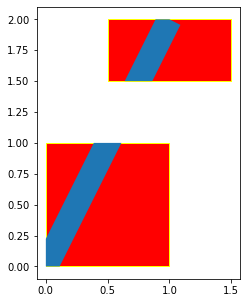

In [218]:
# boolean linestring buffer with shapely
fig, ax = plt.subplots(1,1, figsize=(5,5))
polys_gdf.plot(ax=ax,facecolor='r', edgecolor='yellow' )
gpd.overlay(buffer_gdf, polys_gdf, how='intersection').plot(ax=ax) 
plt.show()

<AxesSubplot:>

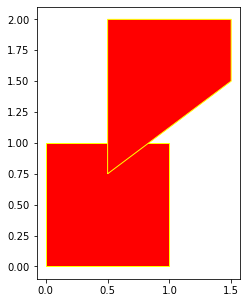

In [229]:
poly_list1 = [Polygon([[0, 0], [1, 0], [1, 1], [0, 1]]), Polygon([[0.5, 0.75], [1.5, 1.5], [1.5, 2], [0.5, 2]])]

polys_gdf1 = gpd.GeoDataFrame(geometry=poly_list1)
fig, ax = plt.subplots(1,1, figsize=(5,5))
polys_gdf1.plot(ax=ax,facecolor='r', edgecolor='yellow' )

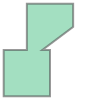

In [230]:
polys_gdf1.unary_union

#### Create road buffer using LION

In [231]:
Lion = gpd.read_file('./Data/Raw_Data/Geo/LION_21A/LION_21A.shp')
Lion.head()

OBJECTID           Street                      SAFStreetN FeatureTyp  \
0       1.0  EAST 168 STREET                            None          0   
1       2.0  WEST 192 STREET                            None          0   
2       3.0     UNION AVENUE                            None          0   
3       4.0     UNION AVENUE  BEHAGEN PLAYGROUND COMFORT STA          0   
4       5.0     UNION AVENUE  BEHAGEN PLAYGROUND FIELD NORTH          0   

  SegmentTyp IncExFlag RB_Layer NonPed TrafDir TrafSrc SpecAddr FaceCode  \
0          U      None        B   None       T     DOT     None     2510   
1          U      None        B   None       A     DOT     None     7984   
2          U      None        B   None       W     DOT     None     7280   
3          U      None        B   None       W     DOT        X     7280   
4          U      None        B   None       W     DOT        X     7280   

  SeqNum StreetCode SAFStreetC LGC1  LGC2  LGC3  LGC4  LGC5  LGC6  LGC7  LGC8  \
0  03070     226700       None   01  None  None  None  None  None  None  None   
1  00040     274810       None   01  None  None  None  None  None  None  None   
2  00130     270420       None   01  None  None  None  None  None  None  None   
3  00130     270420     212795   01  None  None  None  None  None  None  None   
4  00130     270420     212795   01  None  None  None  None  None  None  None   

   LGC9 BOE_LGC SegmentID SegCount LocStatus   LZip   RZip  LBoro  RBoro L_CD  \
0  None       1   0078126        1         X  10456  10456    2.0    2.0  203   
1  None       1   0079796        1      None  10468  10468    2.0    2.0  207   
2  None       1   0077356        4         X  10459  10459    2.0    2.0  203   
3  None       1   0077356        4         X  10459  10459    2.0    2.0  203   
4  None       1   0077356        4         X  10459  10459    2.0    2.0  203   

  R_CD LATOMICPOL RATOMICPOL LCT2010 LCT2010Suf RCT2010 RCT2010Suf LCB2010  \
0  203        402        101     149       None     185       None    3001   
1  207        302        104     265       None     265       None    2000   
2  203        402        401     135       None     131       None    2000   
3  203        402        401     135       None     131       None    2000   
4  203        402        401     135       None     131       None    2000   

  LCB2010Suf RCB2010 RCB2010Suf LCT2000 LCT2000Suf RCT2000 RCT2000Suf LCB2000  \
0       None    2000       None     149       None     137       None    4000   
1       None    1004       None     265       None     265       None    3001   
2       None    3006       None     135       None     131       None    4000   
3       None    3006       None     135       None     131       None    4000   
4       None    3006       None     135       None     131       None    4000   

  LCB2000Suf RCB2000 RCB2000Suf LCT1990 LCT1990Suf RCT1990 RCT1990Suf  \
0       None    1000       None     149       None     137       None   
1       None    1003       None     265       None     265       None   
2       None    4001       None     135       None     131       None   
3       None    4001       None     135       None     131       None   
4       None    4001       None     135       None     131       None   

  LAssmDist LElectDist RAssmDist RElectDist SplitElect LSchlDist RSchlDist  \
0        79        040        79        040       None        09        09   
1        78        045        78        059       None        10        10   
2        79        046        79        026       None        12        12   
3        79        046        79        026       None        12        12   
4        79        046        79        026       None        12        12   

  SplitSchl LSubSect RSubSect SanDistInd MapFrom MapTo BoroBndry MH_RI_Flag  \
0      None       1B       1B       None      3D    3D      None       None   
1      None       1A       1A       None      3C    3C      None       None   
2      None       1A

In [252]:
road = Lion[Lion['RW_TYPE'] == '1'] # keep only street road (no highway)
road = road[road['NonPed'] != 'V'] #filter out roads without sidewalks
road = road[road['StreetWidt'] > 0] # keep street width greater than 0
road = road.reset_index(drop=True)
road.head()

OBJECTID           Street                      SAFStreetN FeatureTyp  \
0       1.0  EAST 168 STREET                            None          0   
1       2.0  WEST 192 STREET                            None          0   
2       3.0     UNION AVENUE                            None          0   
3       4.0     UNION AVENUE  BEHAGEN PLAYGROUND COMFORT STA          0   
4       5.0     UNION AVENUE  BEHAGEN PLAYGROUND FIELD NORTH          0   

  SegmentTyp IncExFlag RB_Layer NonPed TrafDir TrafSrc SpecAddr FaceCode  \
0          U      None        B   None       T     DOT     None     2510   
1          U      None        B   None       A     DOT     None     7984   
2          U      None        B   None       W     DOT     None     7280   
3          U      None        B   None       W     DOT        X     7280   
4          U      None        B   None       W     DOT        X     7280   

  SeqNum StreetCode SAFStreetC LGC1  LGC2  LGC3  LGC4  LGC5  LGC6  LGC7  LGC8  \
0  03070     226700       None   01  None  None  None  None  None  None  None   
1  00040     274810       None   01  None  None  None  None  None  None  None   
2  00130     270420       None   01  None  None  None  None  None  None  None   
3  00130     270420     212795   01  None  None  None  None  None  None  None   
4  00130     270420     212795   01  None  None  None  None  None  None  None   

   LGC9 BOE_LGC SegmentID SegCount LocStatus   LZip   RZip  LBoro  RBoro L_CD  \
0  None       1   0078126        1         X  10456  10456    2.0    2.0  203   
1  None       1   0079796        1      None  10468  10468    2.0    2.0  207   
2  None       1   0077356        4         X  10459  10459    2.0    2.0  203   
3  None       1   0077356        4         X  10459  10459    2.0    2.0  203   
4  None       1   0077356        4         X  10459  10459    2.0    2.0  203   

  R_CD LATOMICPOL RATOMICPOL LCT2010 LCT2010Suf RCT2010 RCT2010Suf LCB2010  \
0  203        402        101     149       None     185       None    3001   
1  207        302        104     265       None     265       None    2000   
2  203        402        401     135       None     131       None    2000   
3  203        402        401     135       None     131       None    2000   
4  203        402        401     135       None     131       None    2000   

  LCB2010Suf RCB2010 RCB2010Suf LCT2000 LCT2000Suf RCT2000 RCT2000Suf LCB2000  \
0       None    2000       None     149       None     137       None    4000   
1       None    1004       None     265       None     265       None    3001   
2       None    3006       None     135       None     131       None    4000   
3       None    3006       None     135       None     131       None    4000   
4       None    3006       None     135       None     131       None    4000   

  LCB2000Suf RCB2000 RCB2000Suf LCT1990 LCT1990Suf RCT1990 RCT1990Suf  \
0       None    1000       None     149       None     137       None   
1       None    1003       None     265       None     265       None   
2       None    4001       None     135       None     131       None   
3       None    4001       None     135       None     131       None   
4       None    4001       None     135       None     131       None   

  LAssmDist LElectDist RAssmDist RElectDist SplitElect LSchlDist RSchlDist  \
0        79        040        79        040       None        09        09   
1        78        045        78        059       None        10        10   
2        79        046        79        026       None        12        12   
3        79        046        79        026       None        12        12   
4        79        046        79        026       None        12        12   

  SplitSchl LSubSect RSubSect SanDistInd MapFrom MapTo BoroBndry MH_RI_Flag  \
0      None       1B       1B       None      3D    3D      None       None   
1      None       1A       1A       None      3C    3C      None       None   
2      None       1A

In [253]:
road.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [260]:
road_Buffer = pd.DataFrame()
for i,j in enumerate(road['StreetWidt']):
    road_Buffer = road_Buffer.append(pd.DataFrame(road.loc[[i]]['geometry'].buffer(distance=j/2)))

In [261]:
road_Buffer = gpd.GeoDataFrame(geometry=road_Buffer[0], crs=2263)
road_Buffer.head()

geometry
0  POLYGON ((1011276.540 241567.870, 1011277.754 ...
1  POLYGON ((1011327.618 255150.988, 1011326.383 ...
2  POLYGON ((1011769.574 240234.798, 1011770.151 ...
3  POLYGON ((1011769.574 240234.798, 1011770.151 ...
4  POLYGON ((1011769.574 240234.798, 1011770.151 ...

In [262]:
merge = road_Buffer.geometry.unary_union #Merge all roads into multipolygons
polys = [poly for poly in merge]
road_poly = gpd.GeoDataFrame(geometry=polys, crs=2263)
road_poly.head()

geometry
0  POLYGON ((916069.897 121088.912, 916069.320 12...
1  POLYGON ((1004121.409 140401.167, 1004121.960 ...
2  POLYGON ((1015982.145 145827.904, 1015982.279 ...
3  POLYGON ((1015846.832 146005.426, 1015847.315 ...
4  POLYGON ((984884.177 147511.274, 984884.498 14...

In [263]:
# save this geo file
road_poly.to_file('./Data/Processed_Data/road_poly.geojson', driver='GeoJSON')

In [269]:
# load census tract data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson').to_crs(2263)
ct2010.head()

boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0         5    5000900  Staten Island          E  000900       9    SI22   
1         1    1009800      Manhattan          I  009800      98    MN19   
2         1    1010200      Manhattan          I  010200     102    MN17   
3         1    1010400      Manhattan          I  010400     104    MN17   
4         1    1011300      Manhattan          I  011300     113    MN17   

                                     ntaname  puma    shape_area   shape_leng  \
0  West New Brighton-New Brighton-St. George  3903  2.497010e+06  7729.016794   
1                    Turtle Bay-East Midtown  3808  1.906016e+06  5534.200308   
2                      Midtown-Midtown South  3807  1.860993e+06  5687.802439   
3                      Midtown-Midtown South  3807  1.864600e+06  5693.036367   
4                      Midtown-Midtown South  3807  1.890907e+06  5699.860640   

         GeoID                                           geometry  
0  36085000900  POLYGON ((962269.126 173705.500, 962288.722 17...  
1  36061009800  POLYGON ((994133.507 214848.898, 994005.909 21...  
2  36061010200  POLYGON ((992216.539 216507.687, 992091.031 21...  
3  36061010400  POLYGON ((991325.882 217001.689, 991199.221 21...  
4  36061011300  POLYGON ((988650.277 214286.402, 988517.806 21...

In [270]:
# Boolean operations 
ct_road = gpd.overlay(road_poly, ct2010, how='intersection')

In [282]:
ct_road['road_area'] = ct_road.area
ct_road = ct_road.groupby('GeoID').agg({'road_area':'sum'})
ct_road.head()

road_area
GeoID                    
36005000100  1.566373e+06
36005000200  7.869340e+05
36005000400  1.172759e+06
36005001600  9.659733e+05
36005001900  2.085712e+06

In [283]:
ct_road

road_area
GeoID                    
36005000100  1.566373e+06
36005000200  7.869340e+05
36005000400  1.172759e+06
36005001600  9.659733e+05
36005001900  2.085712e+06
...                   ...
36085030301  1.358868e+06
36085030302  1.316955e+06
36085031901  6.127782e+05
36085031902  7.913618e+05
36085032300  1.181451e+06

[2162 rows x 1 columns]

#### sidewalk area

In [286]:
sidewalk = gpd.read_file('./Data/Raw_Data/Geo/Sidewalk/geo_export_4545b2ef-102b-4fd5-aacd-c0b896e7881c.shp').to_crs(2263)
sidewalk.head()

feat_code    shape_area   shape_leng     source_id     status  sub_code  \
0     3800.0  12252.910554  1763.887092  2.138000e+10  Unchanged  380000.0   
1     3800.0   5784.683784  1004.777693  2.138000e+10  Unchanged  380000.0   
2     3800.0   2662.091456   828.312364  2.138000e+10  Unchanged  380000.0   
3     3800.0     77.343809    38.361842  2.138000e+10  Unchanged  380000.0   
4     3800.0  31976.407120  5063.776578  2.138000e+10    Updated  380000.0   

                                            geometry  
0  POLYGON ((984808.223 190837.194, 984802.411 19...  
1  POLYGON ((985043.926 190997.138, 985062.305 19...  
2  POLYGON ((989755.070 195457.325, 989753.092 19...  
3  POLYGON ((986680.772 193019.650, 986680.769 19...  
4  POLYGON ((989716.779 194185.507, 989795.408 19...

In [287]:
# Boolean operations 
ct_side = gpd.overlay(sidewalk, ct2010, how='intersection')

In [290]:
ct_side['walk_area'] = ct_side.area
ct_side = ct_side.groupby('GeoID').agg({'walk_area':'sum'})
ct_side.head()

walk_area
GeoID                    
36005000100  9.855936e+04
36005000200  2.916085e+05
36005000400  5.014021e+05
36005001600  4.746538e+05
36005001900  1.021118e+06

In [334]:
# merge
BE_WalkVSDrive = pd.merge(ct_road,ct_side, left_index=True, right_index=True)

In [340]:
BE_WalkVSDrive['BE_WalkVSDrive'] = BE_WalkVSDrive['walk_area']/BE_WalkVSDrive.sum(axis=1)
BE_WalkVSDrive = BE_WalkVSDrive[['BE_WalkVSDrive']]
BE_WalkVSDrive.head()

BE_WalkVSDrive
GeoID                      
36005000100        0.059197
36005000200        0.270373
36005000400        0.299495
36005001600        0.329477
36005001900        0.328669

In [342]:
BE_WalkVSDrive.describe()

BE_WalkVSDrive
count     2162.000000
mean         0.367434
std          0.066568
min          0.059197
25%          0.330679
50%          0.361569
75%          0.395813
max          0.855943

In [343]:
# save this geo file
BE_WalkVSDrive.to_csv('./Data/Processed_Data/BE_WalkVSDrive.csv')

### BE_Transit:  
**Description:** Numbers of Transits(train, subway, bus, or ferry stop.) within 15 min walk distance (0.8 mile)

**Method:** Calculate the number of Transits within 0.8 miles of the census block's centroid, then average the census block values that correspond to the census tract .

**Data Source:** OpenStreetMap(OSM) via osmnx library

**Geography:** Point/census block/census tract

**Date:** 2022

In [31]:
place = 'New York, USA'
tags = {'public_transport':'stop_position'} 
transit = ox.geometries_from_place(place, tags=tags)
transit = transit[transit.geom_type == 'Point'].reset_index()[['public_transport','geometry']]
transit = transit.to_crs(2263)
transit.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [32]:
cb2010_Buffer = gpd.read_file('./Data/Processed_Data/cb2010_Buffer.geojson')
cb2010_Buffer.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [33]:
# spatial join with cb2010_Buffer
BE_Transit = gpd.sjoin(transit, cb2010_Buffer, how="right", op='intersects')
BE_Transit = BE_Transit.groupby('BCTCB2010').agg({'public_transport':'count','GeoID':'mean'})
BE_Transit['GeoID'] = BE_Transit['GeoID'].astype('int')
BE_Transit = BE_Transit.groupby('GeoID').agg({'public_transport':'mean'}).reset_index().rename(columns={'public_transport':'BE_Transit'})
BE_Transit.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


GeoID  BE_Transit
0  36005000100    2.000000
1  36005000200    4.478261
2  36005000400    3.358974
3  36005001600    9.700000
4  36005001900   19.677419

In [34]:
BE_Transit.describe()

GeoID   BE_Transit
count  2.165000e+03  2165.000000
mean   3.605475e+10    29.470933
std    2.595373e+07    29.162324
min    3.600500e+10     0.000000
25%    3.604703e+10    11.925000
50%    3.604712e+10    20.538462
75%    3.608103e+10    36.571429
max    3.608599e+10   204.375000

In [35]:
# save file
BE_Transit.to_csv("./Data/Processed_Data/BE_Transit.csv")

### BE_BikeD: 

**Description:** Bike lanes density

**Data Source:** DOT

https://data.cityofnewyork.us/Transportation/New-York-City-Bike-Routes/7vsa-caz7

**Geography:** linestring/Census Tract
**Date:** Apr 21, 2022

In [6]:
Bike = gpd.read_file('./Data/Raw_Data/Built_Environment/Bike_Routes/geo_export_678d2a4e-eb60-42e0-87c6-44af62b25904.shp').to_crs(2263)
Bike.head()

allclasses bikedir  boro comments facilitycl  fromstreet ft2facilit  \
0          I       2   5.0     None          I  HYLAN BLVD       None   
1          I       2   5.0     None          I  HYLAN BLVD       None   
2          I       2   5.0     None          I  HYLAN BLVD       None   
3          I       2   5.0     None          I  HYLAN BLVD       None   
4          I       2   5.0     None          I  HYLAN BLVD       None   

  ft_facilit  lanecount onoffst  segmentid  shape_le_1  \
0   Greenway        2.0     OFF       53.0  131.771990   
1   Greenway        2.0     OFF       57.0  268.689582   
2   Greenway        2.0     OFF       59.0  420.193253   
3   Greenway        2.0     OFF       61.0  238.242198   
4   Greenway        2.0     OFF       64.0  646.293832   

                           street tf2facilit tf_facilit       tostreet  \
0  CONFERENCE HOUSE PARK GREENWAY       None   Greenway  SWINNERTON ST   
1  CONFERENCE HOUSE PARK GREENWAY       None   Greenway  SWINNERTON ST   
2  CONFERENCE HOUSE PARK GREENWAY       None   Greenway  SWINNERTON ST   
3  CONFERENCE HOUSE PARK GREENWAY       None   Greenway  SWINNERTON ST   
4  CONFERENCE HOUSE PARK GREENWAY       None   Greenway  SWINNERTON ST   

                                            geometry  
0  LINESTRING (914742.992 121858.565, 914808.853 ...  
1  LINESTRING (914955.193 121071.349, 914902.953 ...  
2  LINESTRING (914902.953 121334.911, 914808.853 ...  
3  LINESTRING (914209.939 122562.904, 914233.063 ...  
4  LINESTRING (914353.678 122374.442, 914742.992 ...

In [24]:
# load census tract data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson').to_crs(2263)
ct2010.head()

boro_code boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0         5    5000900  Staten Island          E  000900       9    SI22   
1         1    1009800      Manhattan          I  009800      98    MN19   
2         1    1010200      Manhattan          I  010200     102    MN17   
3         1    1010400      Manhattan          I  010400     104    MN17   
4         1    1011300      Manhattan          I  011300     113    MN17   

                                     ntaname  puma    shape_area   shape_leng  \
0  West New Brighton-New Brighton-St. George  3903  2.497010e+06  7729.016794   
1                    Turtle Bay-East Midtown  3808  1.906016e+06  5534.200308   
2                      Midtown-Midtown South  3807  1.860993e+06  5687.802439   
3                      Midtown-Midtown South  3807  1.864600e+06  5693.036367   
4                      Midtown-Midtown South  3807  1.890907e+06  5699.860640   

         GeoID                                           geometry  
0  36085000900  POLYGON ((962269.126 173705.500, 962288.722 17...  
1  36061009800  POLYGON ((994133.507 214848.898, 994005.909 21...  
2  36061010200  POLYGON ((992216.539 216507.687, 992091.031 21...  
3  36061010400  POLYGON ((991325.882 217001.689, 991199.221 21...  
4  36061011300  POLYGON ((988650.277 214286.402, 988517.806 21...

In [28]:
# spatial join with census tract
Bike_ct = gpd.sjoin(Bike, ct2010, how="inner", op='intersects')
Bike_ct.head()

allclasses bikedir  boro comments facilitycl  fromstreet ft2facilit  \
0          I       2   5.0     None          I  HYLAN BLVD       None   
1          I       2   5.0     None          I  HYLAN BLVD       None   
2          I       2   5.0     None          I  HYLAN BLVD       None   
3          I       2   5.0     None          I  HYLAN BLVD       None   
4          I       2   5.0     None          I  HYLAN BLVD       None   

  ft_facilit  lanecount onoffst  segmentid  shape_le_1  \
0   Greenway        2.0     OFF       53.0  131.771990   
1   Greenway        2.0     OFF       57.0  268.689582   
2   Greenway        2.0     OFF       59.0  420.193253   
3   Greenway        2.0     OFF       61.0  238.242198   
4   Greenway        2.0     OFF       64.0  646.293832   

                           street tf2facilit tf_facilit       tostreet  \
0  CONFERENCE HOUSE PARK GREENWAY       None   Greenway  SWINNERTON ST   
1  CONFERENCE HOUSE PARK GREENWAY       None   Greenway  SWINNERTON ST   
2  CONFERENCE HOUSE PARK GREENWAY       None   Greenway  SWINNERTON ST   
3  CONFERENCE HOUSE PARK GREENWAY       None   Greenway  SWINNERTON ST   
4  CONFERENCE HOUSE PARK GREENWAY       None   Greenway  SWINNERTON ST   

                                            geometry  index_right boro_code  \
0  LINESTRING (914742.992 121858.565, 914808.853 ...         2070         5   
1  LINESTRING (914955.193 121071.349, 914902.953 ...         2070         5   
2  LINESTRING (914902.953 121334.911, 914808.853 ...         2070         5   
3  LINESTRING (914209.939 122562.904, 914233.063 ...         2070         5   
4  LINESTRING (914353.678 122374.442, 914742.992 ...         2070         5   

  boro_ct201      boro_name cdeligibil  ct2010 ctlabel ntacode  \
0    5024402  Staten Island          I  024402  244.02    SI11   
1    5024402  Staten Island          I  024402  244.02    SI11   
2    5024402  Staten Island          I  024402  244.02    SI11   
3    5024402  Staten Island          I  024402  244.02    SI11   
4    5024402  Staten Island          I  024402  244.02    SI11   

                                  ntaname  puma    shape_area    shape_leng  \
0  Charleston-Richmond Valley-Tottenville  3901  1.913807e+07  22667.414766   
1  Charleston-Richmond Valley-Tottenville  3901  1.913807e+07  22667.414766   
2  Charleston-Richmond Valley-Tottenville  3901  1.913807e+07  22667.414766   
3  Charleston-Richmond Valley-Tottenville  3901  1.913807e+07  22667.414766   
4  Charleston-Richmond Valley-Tottenville  3901  1.913807e+07  22667.414766   

         GeoID  
0  36085024402  
1  36085024402  
2  36085024402  
3  36085024402  
4  36085024402

In [29]:
Bike_ct['BE_Bike'] = Bike_ct['shape_le_1']*Bike_ct['lanecount']
BE_BikeD = Bike_ct.groupby('GeoID').agg({'BE_Bike':'sum'})
BE_BikeD.head()

BE_Bike
GeoID                    
36005000200   2411.742451
36005000400  26883.074164
36005001600   8348.872648
36005001900  23728.829562
36005002000   3177.599624

In [30]:
BE_BikeD = BE_BikeD.merge(ct2010[['GeoID','shape_area']], left_index=True, right_on='GeoID')
BE_BikeD['BE_BikeD'] = BE_BikeD['BE_Bike']/(BE_BikeD['shape_area']/43560)
BE_BikeD.head()

BE_Bike        GeoID    shape_area    BE_BikeD
2157   2411.742451  36005000200  5.009780e+06   20.970083
1374  26883.074164  36005000400  8.557953e+06  136.834909
994    8348.872648  36005001600  5.221330e+06   69.652155
1945  23728.829562  36005001900  1.796100e+07   57.548454
1060   3177.599624  36005002000  4.336906e+06   31.915893

In [32]:
BE_BikeD = BE_BikeD[['GeoID','BE_BikeD']]

In [33]:
# save file
BE_BikeD.to_csv("./Data/Processed_Data/BE_BikeD.csv")

### BE_nodeD:  
**Description:** 15min walking distance Intersection density in terms of pedestrian-oriented intersections.(number of intersection per acre)

**Data Source:** OpenStreetMap(OSM) via osmnx library

**Geography:** Point/census tract

**Date:** 2022

In [3]:
place = 'New York, USA'

In [4]:
graph = ox.graph_from_place(place, network_type='walk')

In [5]:
Walk_nodes, Walk_streets = ox.graph_to_gdfs(graph)
Walk_nodes.head()

y          x  street_count          highway  ref  \
osmid                                                                
30807314  40.790720 -73.963576             4              NaN  NaN   
30978752  40.774776 -73.974360             4              NaN  NaN   
42421728  40.798048 -73.960044             4  traffic_signals  NaN   
42421731  40.798654 -73.961474             4  traffic_signals  NaN   
42421737  40.799244 -73.962873             4  traffic_signals  NaN   

                            geometry  
osmid                                 
30807314  POINT (-73.96358 40.79072)  
30978752  POINT (-73.97436 40.77478)  
42421728  POINT (-73.96004 40.79805)  
42421731  POINT (-73.96147 40.79865)  
42421737  POINT (-73.96287 40.79924)

In [6]:
len(Walk_nodes)

180765

In [7]:
# read census block data
cb2010_Buffer = gpd.read_file('./Data/Processed_Data/cb2010_Buffer.geojson')
cb2010_Buffer.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [11]:
Walk_nodes = Walk_nodes.to_crs(2263)
Walk_nodes.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
Walk_nodes

y          x  street_count          highway  ref  \
osmid                                                                  
30807314    40.790720 -73.963576             4              NaN  NaN   
30978752    40.774776 -73.974360             4              NaN  NaN   
42421728    40.798048 -73.960044             4  traffic_signals  NaN   
42421731    40.798654 -73.961474             4  traffic_signals  NaN   
42421737    40.799244 -73.962873             4  traffic_signals  NaN   
...               ...        ...           ...              ...  ...   
9683429910  40.756368 -73.960409             4              NaN  NaN   
9683429912  40.790378 -73.946040             3              NaN  NaN   
9683760034  40.748551 -73.730459             1              NaN  NaN   
9683760151  40.754145 -73.717727             3              NaN  NaN   
9683760153  40.754273 -73.718337             1              NaN  NaN   

                                  geometry  
osmid                                       
30807314     POINT (994335.822 227359.782)  
30978752     POINT (991351.478 221549.601)  
42421728     POINT (995312.821 230029.833)  
42421731     POINT (994916.574 230250.589)  
42421737     POINT (994529.169 230465.197)  
...                                    ...  
9683429910   POINT (995218.571 214844.507)  
9683429912   POINT (999191.817 227237.429)  
9683760034  POINT (1058933.978 212108.727)  
9683760151  POINT (1062455.134 214157.866)  
9683760153  POINT (1062286.008 214204.102)  

[180765 rows x 6 columns]

In [20]:
# spatial join with census tract
BE_nodeD = gpd.sjoin(Walk_nodes, cb2010_Buffer, how="right", op='intersects')
BE_nodeD = BE_nodeD.groupby('BCTCB2010').agg({'x':'count','GeoID':'mean'})
BE_nodeD['GeoID'] = BE_nodeD['GeoID'].astype('int')
BE_nodeD.head()

x        GeoID
BCTCB2010                     
10001001000     0  36061000100
10001001001     0  36061000100
10002011000  3666  36061000201
10002011001  3495  36061000201
10002012000  3277  36061000201

In [21]:
BE_nodeD = BE_nodeD.groupby('GeoID').agg({'x':'mean'}).reset_index().rename(columns={'x':'BE_nodeD'})
BE_nodeD.head()

GeoID     BE_nodeD
0  36005000100    53.307692
1  36005000200  1292.521739
2  36005000400  1353.743590
3  36005001600  2556.000000
4  36005001900   836.827957

In [23]:
# save file
BE_nodeD.to_csv("./Data/Processed_Data/BE_nodeD.csv")

### Merge Data

In [4]:
BE_BikeD = pd.read_csv('./Data/Processed_Data/BE_BikeD.csv', index_col=0)
BE_TreeD = pd.read_csv('./Data/Processed_Data/BE_TreeD.csv', index_col=0)
BE_nodeD = pd.read_csv("./Data/Processed_Data/BE_nodeD.csv", index_col=0)
BE_HFood = pd.read_csv("./Data/Processed_Data/BE_HFood.csv", index_col=0)
BE_WalkVSDrive = pd.read_csv('./Data/Processed_Data/BE_WalkVSDrive.csv')
BE_Transit = pd.read_csv('./Data/Processed_Data/BE_Transit.csv', index_col=0)
BE_Park = pd.read_csv('./Data/Processed_Data/BE_Park.csv', index_col=0)
BE_LandUseMix = pd.read_csv('./Data/Processed_Data/BE_LandUseMix.csv')

In [5]:
from functools import reduce
dfs = [BE_TreeD, BE_HFood, BE_Park, BE_LandUseMix, BE_WalkVSDrive, BE_nodeD, BE_Transit, BE_BikeD]
Built_Environment  = reduce(lambda left,right: pd.merge(left,right, on='GeoID', how='outer'), dfs)

In [6]:
Built_Environment

BE_TreeD        GeoID  BE_HFood     BE_Park  BE_LandUseMix  \
0     4.503907  36005000200  0.000000  117.919240       0.160274   
1     4.743943  36005000400  0.000000   81.596888       0.392961   
2     4.421632  36005001600  1.000000  142.340526       0.442828   
3     1.428475  36005001900  1.107527  149.885542       0.461624   
4     5.062189  36005002000  1.055556  206.998551       0.274914   
...        ...          ...       ...         ...            ...   
2160       NaN  36047070203  0.000000   32.571426       0.000000   
2161       NaN  36061000100  0.000000   41.624148       0.000000   
2162       NaN  36061000500  0.512195  174.523601       0.480344   
2163       NaN  36081091602  0.088235  450.659674       0.000000   
2164       NaN  36085990100  0.000000   10.041025       0.000000   

      BE_WalkVSDrive     BE_nodeD  BE_Transit    BE_BikeD  
0           0.270373  1292.521739    4.478261   20.970083  
1           0.299495  1353.743590    3.358974  136.834909  
2           0.329477  2556.000000    9.700000   69.652155  
3           0.328669   836.827957   19.677419   57.548454  
4           0.427229  2355.944444   11.166667   31.915893  
...              ...          ...         ...         ...  
2160             NaN    17.000000    0.250000         NaN  
2161             NaN     0.000000    0.000000         NaN  
2162        0.350529   188.365854    2.097561  301.781868  
2163        0.159136   534.617647    2.558824   80.580000  
2164             NaN     0.000000    0.000000         NaN  

[2165 rows x 9 columns]

In [7]:
Built_Environment = Built_Environment.fillna(0)

In [8]:
Built_Environment

BE_TreeD        GeoID  BE_HFood     BE_Park  BE_LandUseMix  \
0     4.503907  36005000200  0.000000  117.919240       0.160274   
1     4.743943  36005000400  0.000000   81.596888       0.392961   
2     4.421632  36005001600  1.000000  142.340526       0.442828   
3     1.428475  36005001900  1.107527  149.885542       0.461624   
4     5.062189  36005002000  1.055556  206.998551       0.274914   
...        ...          ...       ...         ...            ...   
2160  0.000000  36047070203  0.000000   32.571426       0.000000   
2161  0.000000  36061000100  0.000000   41.624148       0.000000   
2162  0.000000  36061000500  0.512195  174.523601       0.480344   
2163  0.000000  36081091602  0.088235  450.659674       0.000000   
2164  0.000000  36085990100  0.000000   10.041025       0.000000   

      BE_WalkVSDrive     BE_nodeD  BE_Transit    BE_BikeD  
0           0.270373  1292.521739    4.478261   20.970083  
1           0.299495  1353.743590    3.358974  136.834909  
2           0.329477  2556.000000    9.700000   69.652155  
3           0.328669   836.827957   19.677419   57.548454  
4           0.427229  2355.944444   11.166667   31.915893  
...              ...          ...         ...         ...  
2160        0.000000    17.000000    0.250000    0.000000  
2161        0.000000     0.000000    0.000000    0.000000  
2162        0.350529   188.365854    2.097561  301.781868  
2163        0.159136   534.617647    2.558824   80.580000  
2164        0.000000     0.000000    0.000000    0.000000  

[2165 rows x 9 columns]

In [69]:
# geo data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson')
ct2010.head()

dataGeo = pd.merge(Built_Environment, ct2010[['GeoID','boro_name','geometry']], left_on='GeoID', right_on='GeoID').set_index('GeoID')
dataGeo =gpd.GeoDataFrame(dataGeo, geometry=dataGeo.geometry, crs=4326).to_crs(2263)
dataGeo.head()

BE_TreeD  BE_HFood     BE_Park  BE_LandUseMix  BE_WalkVSDrive  \
GeoID                                                                        
36005000200  4.503907  0.000000  117.919240       0.160274        0.270373   
36005000400  4.743943  0.000000   81.596888       0.392961        0.299495   
36005001600  4.421632  1.000000  142.340526       0.442828        0.329477   
36005001900  1.428475  1.107527  149.885542       0.461624        0.328669   
36005002000  5.062189  1.055556  206.998551       0.274914        0.427229   

                BE_nodeD  BE_Transit    BE_BikeD boro_name  \
GeoID                                                        
36005000200  1292.521739    4.478261   20.970083     Bronx   
36005000400  1353.743590    3.358974  136.834909     Bronx   
36005001600  2556.000000    9.700000   69.652155     Bronx   
36005001900   836.827957   19.677419   57.548454     Bronx   
36005002000  2355.944444   11.166667   31.915893     Bronx   

                                                      geometry  
GeoID                                                           
36005000200  POLYGON ((1023972.528 232680.658, 1023970.431 ...  
36005000400  POLYGON ((1026849.274 235548.774, 1026749.976 ...  
36005001600  POLYGON ((1024344.112 238946.021, 1024391.333 ...  
36005001900  MULTIPOLYGON (((1012821.806 229228.265, 101278...  
36005002000  POLYGON ((1022317.859 237780.872, 1022425.769 ...

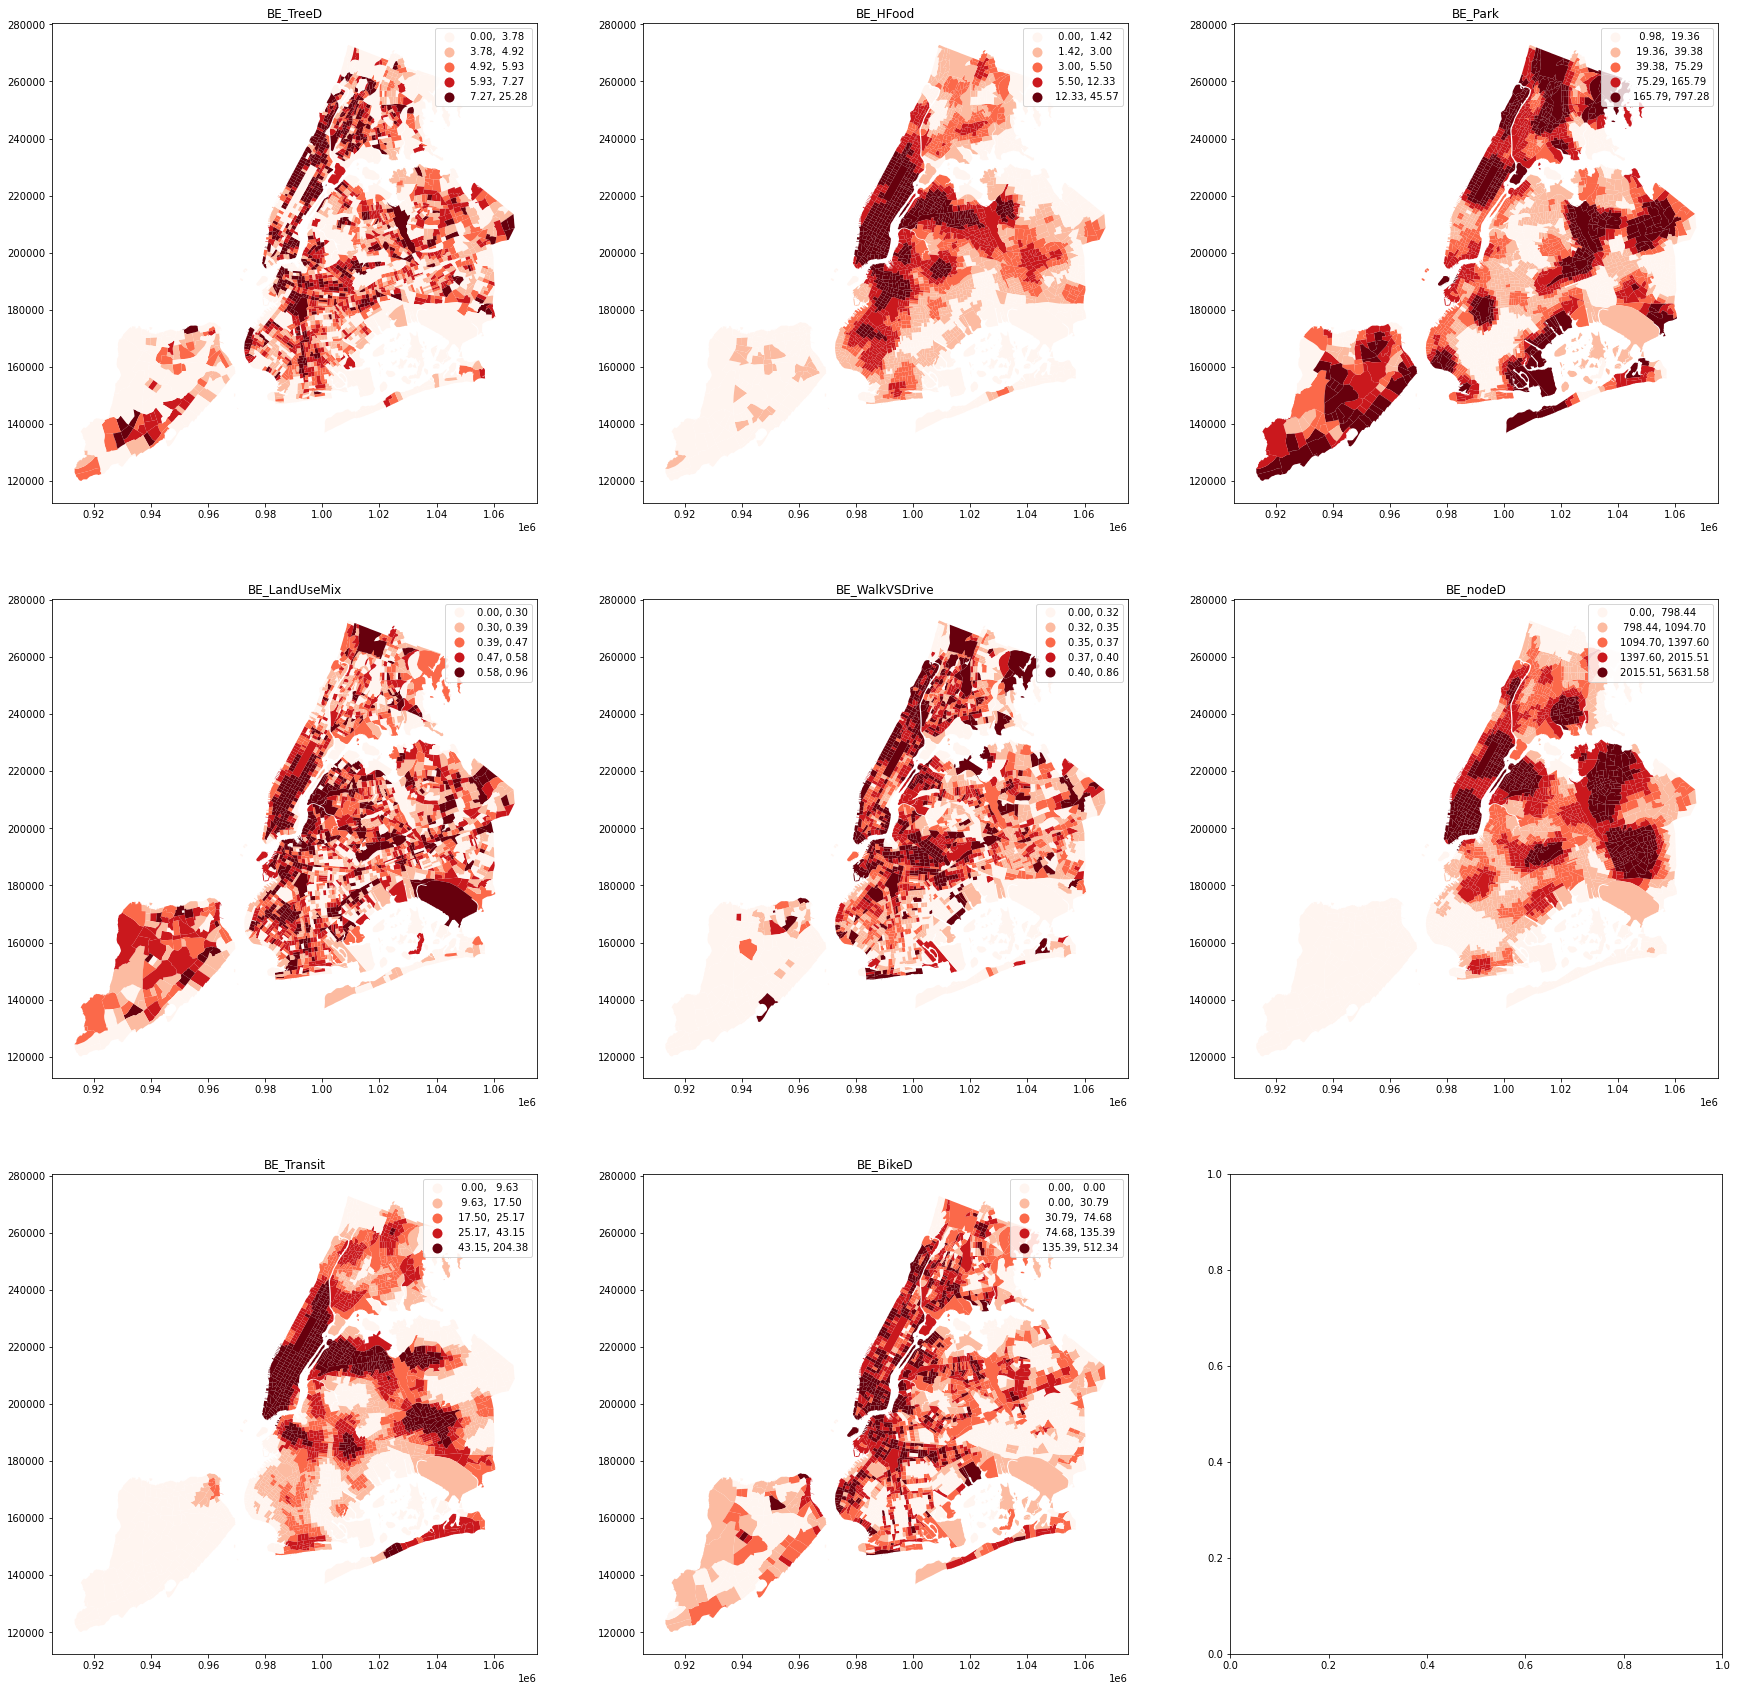

In [71]:
fig, ax = plt.subplots(3,3, figsize=(30,30))

a = dataGeo.columns[:-2]

for i,j in enumerate(a):
    dataGeo.plot(column=j, cmap='Reds', ax=ax[i//3][i%3],
                              legend=True, scheme='Quantiles', k=5,
                              figsize=(5,5))
    label = j
    ax[i//3][i%3].set_title(label)
    
plt.show()

In [53]:
# weighted by population
Pop = pd.read_csv('./Data/Processed_Data/Domain/Population.csv')
Pop.head()

LocationID  TotalPopulation
0  36005000100          11091.0
1  36005000200           4334.0
2  36005000400           5503.0
3  36005001600           5643.0
4  36005001900           1917.0

In [54]:
Built_Environment = pd.merge(Built_Environment,Pop, left_on='GeoID', right_on='LocationID', how='inner')
Built_Environment.head()

BE_TreeD        GeoID  BE_HFood     BE_Park  BE_LandUseMix  BE_WalkVSDrive  \
0  4.503907  36005000200  0.000000  117.919240       0.160274        0.270373   
1  4.743943  36005000400  0.000000   81.596888       0.392961        0.299495   
2  4.421632  36005001600  1.000000  142.340526       0.442828        0.329477   
3  1.428475  36005001900  1.107527  149.885542       0.461624        0.328669   
4  5.062189  36005002000  1.055556  206.998551       0.274914        0.427229   

      BE_nodeD  BE_Transit    BE_BikeD   LocationID  TotalPopulation  
0  1292.521739    4.478261   20.970083  36005000200           4334.0  
1  1353.743590    3.358974  136.834909  36005000400           5503.0  
2  2556.000000    9.700000   69.652155  36005001600           5643.0  
3   836.827957   19.677419   57.548454  36005001900           1917.0  
4  2355.944444   11.166667   31.915893  36005002000           8731.0

In [55]:
a= ['BE_TreeD','BE_nodeD','BE_HFood','BE_WalkVSDrive','BE_Transit','BE_Park', 'BE_BikeD'] # without landuse

In [56]:
Built_Environment[a] = Built_Environment[a].div(Built_Environment['TotalPopulation'],axis=0)
Built_Environment = Built_Environment.drop(columns=['LocationID','TotalPopulation'])
Built_Environment

BE_TreeD        GeoID  BE_HFood   BE_Park  BE_LandUseMix  \
0     0.001039  36005000200  0.000000  0.027208       0.160274   
1     0.000862  36005000400  0.000000  0.014828       0.392961   
2     0.000784  36005001600  0.000177  0.025224       0.442828   
3     0.000745  36005001900  0.000578  0.078188       0.461624   
4     0.000580  36005002000  0.000121  0.023708       0.274914   
...        ...          ...       ...       ...            ...   
2112  0.001345  36085031901  0.000613  0.018739       0.352472   
2113  0.000599  36085031902  0.000147  0.020617       0.327844   
2114  0.000191  36085032300  0.000686  0.059551       0.432966   
2115  0.000000  36005000100  0.000000  0.000325       0.000000   
2116  0.000000  36005005300  0.000734  0.027564       0.328629   

      BE_WalkVSDrive  BE_nodeD  BE_Transit  BE_BikeD  
0           0.000062  0.298228    0.001033  0.004839  
1           0.000054  0.246001    0.000610  0.024866  
2           0.000058  0.452951    0.001719  0.012343  
3           0.000171  0.436530    0.010265  0.030020  
4           0.000049  0.269837    0.001279  0.003655  
...              ...       ...         ...       ...  
2112        0.000118  0.000000    0.000000  0.015467  
2113        0.000063  0.000000    0.000000  0.000000  
2114        0.000173  0.000000    0.000000  0.009404  
2115        0.000005  0.004806    0.000180  0.000000  
2116        0.000027  0.354986    0.005538  0.045753  

[2117 rows x 9 columns]

In [9]:
# save file
Built_Environment.to_csv("./Data/Processed_Data/Domain/Built_Environment.csv")